In [1]:
"""import kagglehub
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Download latest version
path = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")

print("Path to dataset files:", path)

# Collect all file names
file_names = [] 
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))"""

'import kagglehub\nfrom scipy.io import loadmat\nimport os\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\n# Download latest version\npath = kagglehub.dataset_download("inancigdem/eeg-data-for-mental-attention-state-detection")\n\nprint("Path to dataset files:", path)\n\n# Collect all file names\nfile_names = [] \nfor dirname, _, filenames in os.walk(path):\n    for filename in filenames:\n        file_names.append(os.path.join(dirname, filename))'

# Load data

In [26]:
from scipy.io import loadmat
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
import mne
from mne.preprocessing import ICA

In [27]:
path = 'C:/Users/Phuong/Pattern-Recognition-EEG/Data'

# Collect all file names
file_names = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.mat'):
            file_names.append(os.path.join(dirname, filename))
        
# Sắp xếp file theo số thứ tự (để đảm bảo đúng thứ tự subject)
file_names.sort(key=lambda x: int(x.split('eeg_record')[-1].split('.mat')[0]))

In [28]:
sampFreq = 128
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

In [29]:
# Hàm đọc dữ liệu 
def load_data(file_name):
    mat = loadmat(file_name)

    # Trích xuất dữ liệu từ đối tượng 'o'
    mdata = mat['o']
    sampFreq = int(mdata['sampFreq'][0][0][0][0])  # Tần số lấy mẫu
    data = mdata['data'][0, 0]  # Dữ liệu đầy đủ

    # Lấy tín hiệu từ các kênh 4–17
    eeg_data = data[:, 3:17]

    return data, eeg_data

In [30]:
def load_eeg_data(file_names):
    all_data = []
    for file_name in file_names:
        # Lấy Trial ID từ tên file
        trial_id = int(file_name.split('eeg_record')[-1].split('.mat')[0])

        try:
            print(f"Đang xử lý file: {file_name}, Trial ID: {trial_id}")
            _, eeg_data = load_data(file_name)

            # Kiểm tra kích thước dữ liệu trả về
            if eeg_data is not None and eeg_data.size > 0:
                all_data.append((eeg_data))
            else:
                print(f"Dữ liệu EEG từ file {file_name} không hợp lệ hoặc rỗng.")
        except Exception as e:
            print(f"Lỗi khi xử lý file {file_name}: {e}")
    
    return all_data

In [31]:
def get_data_5days(full_data):
    num_initial_days=2

    filtered_data_5days = []

    for i in range(5):  # 5 người
        # Số lượng file của mỗi người, người thứ 5 có 6 file, còn lại là 7 file
        num_files = 7 if i != 4 else 6

        # Lấy dữ liệu từ các ngày đo thực sự (bỏ qua 2 ngày đầu)
        real_measurement_files = full_data[i * 7 + num_initial_days: i * 7 + num_files]

        # Thêm dữ liệu vào danh sách kết quả
        filtered_data_5days.extend(real_measurement_files)

    return filtered_data_5days

In [32]:
full_data = load_eeg_data(file_names)
reduce_data_5days = get_data_5days(full_data)

Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record1.mat, Trial ID: 1
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record2.mat, Trial ID: 2
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record3.mat, Trial ID: 3
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record4.mat, Trial ID: 4
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record5.mat, Trial ID: 5
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record6.mat, Trial ID: 6
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record7.mat, Trial ID: 7
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record8.mat, Trial ID: 8
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record9.mat, Trial ID: 9
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record10.mat, Trial ID: 10
Đang xử lý file: C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record11.mat, Trial ID

# Filter data

In [33]:
from scipy.signal import butter, filtfilt, iirnotch

# Hàm tạo bộ lọc thông cao và thông thấp
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# Hàm tạo bộ lọc notch
def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, data, axis=0)

In [34]:
def filter_data(data_set):
    # Lọc thông cao và thông thấp và lọc notch cho từng file
    filtered_all_data = []
    for data_eeg in data_set:
        # Lọc thông cao và thông thấp cho dữ liệu của file hiện tại
        lowcut = 0.5  # Hz
        highcut = 30  # Hz
        filtered_data_bandpass = bandpass_filter(data_eeg, lowcut, highcut, sampFreq)

        # Lọc notch để loại bỏ nhiễu 50 Hz cho dữ liệu đã lọc thông
        notch_freq = 50  # Hz
        filtered_data_notch = notch_filter(filtered_data_bandpass, notch_freq, sampFreq)

        # Lưu dữ liệu đã lọc vào danh sách
        filtered_all_data.append(filtered_data_notch)
    
    return filtered_all_data

In [35]:
filtered_full_data = filter_data(full_data)
filtered_reduce_data = get_data_5days(filtered_full_data)

In [36]:
def plot_all_channels(eeg_data_list, channel_names, title="EEG Signals for All Channels"):

    num_channels = len(channel_names)
    time_range = range(5000, 15000)

    fig, ax = plt.subplots(num_channels, 1)
    fig.set_figwidth(20)
    fig.set_figheight(50)

    for i in range(num_channels):
        combined_data = []
        for eeg_data in eeg_data_list:
            combined_data.extend(eeg_data[time_range, i])
        combined_data = np.array(combined_data)
        data_ave = combined_data - np.mean(combined_data)
        ax[i].plot(data_ave)
        ax[i].set_title(channel_names[i])
        ax[i].set_ylim(-100, 100)

    plt.tight_layout()
    plt.show()


In [37]:
# 'F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4'

# AF3 FC5 T7 T8 FC6 F4 F8 
# 4 5 8 9 10 11 16

In [38]:
plot_all_channels(filtered_reduce_data, channel_names)

In [39]:
# 'F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4'
useful_channels=[1,2,5,6,7,8,13]
useful_channels_names=['F7','F3','P7','O1','O2','P8','AF4']

filtered_full_data_7channel = [eeg_data[:, useful_channels] for eeg_data in filtered_full_data]
filtered_reduce_data_7channel = get_data_5days(filtered_full_data_7channel)

* Visualize data

In [40]:
def analyze_data(filtered_all_data, file_names, subject_map=None, num_files=2):
    # Phân tích dữ liệu
    if subject_map is not None:
        # Chỉ phân tích những file có trong subject_map
        valid_indices = sum(subject_map.values(), [])
        valid_indices = [x - 1 for x in valid_indices]
    else:
        # Phân tích tất cả các file
        valid_indices = list(range(len(file_names)))

    for i in valid_indices[:num_files]:  # Duyệt qua một số file để trực quan hóa
        data, eeg_data = load_data(file_names[i])

        # Vẽ dữ liệu đầy đủ từ file
        print('Dữ liệu đầy đủ từ file {}:'.format(file_names[i]), data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(data)
        plt.title(f'Dữ liệu đầy đủ từ File {i + 1}')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Vẽ dữ liệu từ các kênh 4-17
        print('\nDữ liệu EEG từ các kênh 4-17:', eeg_data.shape)
        plt.figure(figsize=(10, 4))
        plt.plot(eeg_data[:1000, :])  # Giả sử vẽ 1000 mẫu đầu tiên
        plt.title('Data EEG (Channel 4-17) from 1000 data')
        plt.xlabel('Samples')
        plt.ylabel('EEG Signal Amplitude')
        plt.show()

        # Biểu diễn tín hiệu sau khi lọc của 1000 data đầu tiên
        filtered_data = filtered_all_data[i]  # Lấy dữ liệu đã lọc của file thứ i
        plt.figure(figsize=(10, 4))
        plt.plot(filtered_data[:1000, :])  # Lấy 1000 mẫu đầu tiên từ dữ liệu đã lọc
        plt.title('EEG Data After Filtering (High-pass, Low-pass, Notch) from 1000 data')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.show()

Dữ liệu đầy đủ từ file C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record1.mat: (308868, 25)


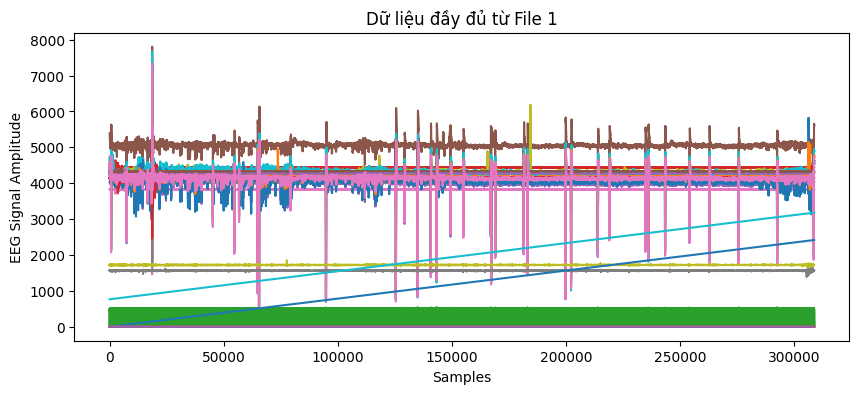


Dữ liệu EEG từ các kênh 4-17: (308868, 14)


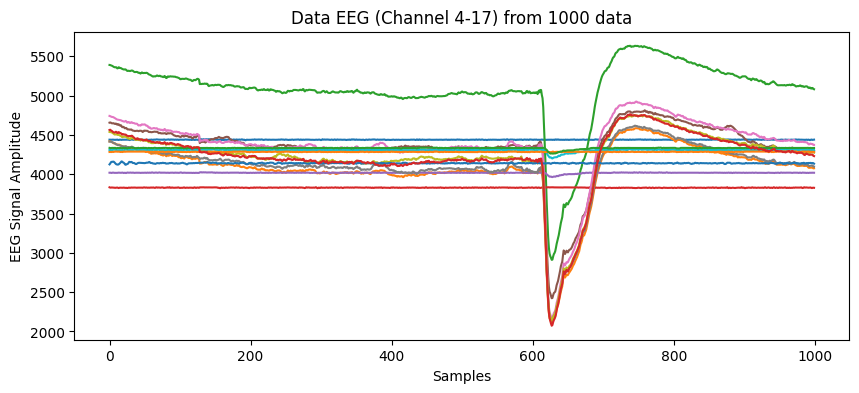

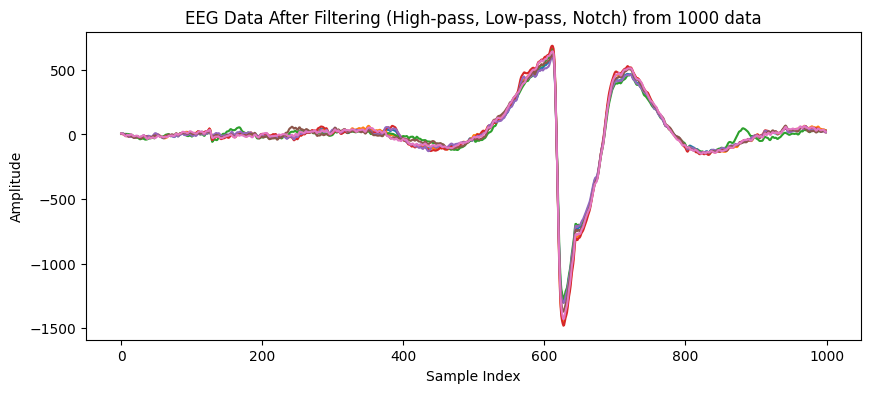

Dữ liệu đầy đủ từ file C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record2.mat: (366020, 25)



Dữ liệu EEG từ các kênh 4-17: (366020, 14)


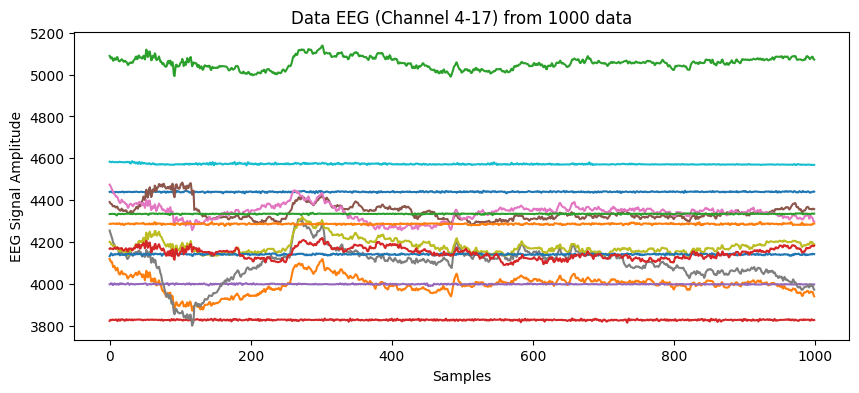

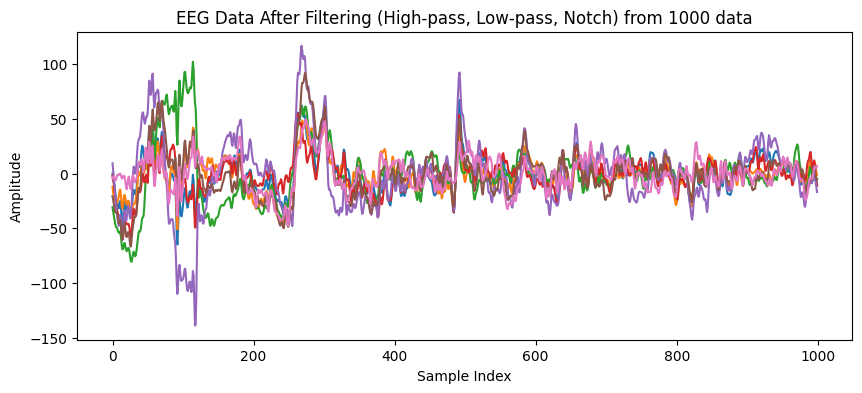

In [41]:
analyze_data(filtered_full_data_7channel, file_names)

In [42]:
# Số tổng subject (5)
total_subjects = 5

# Tạo ánh xạ subject_map, với việc lùi chỉ số
subject_map = {}
for s in range(1, total_subjects + 1):
    # Lùi chỉ số 2 ngày đầu, vì cần bỏ qua 2 ngày thử nghiệm
    a = int(7 * (s - 1)) + 3  # Bắt đầu từ ngày thứ 3
    if s != 5:
        b = a + 5  # Người 1-4 có 5 ngày thực tế
    else:
        b = a + 4  # Người 5 có 4 ngày thực tế
    subject_map[s] = [i for i in range(a, b)]

# In ra subject_map để kiểm tra
print(subject_map)

{1: [3, 4, 5, 6, 7], 2: [10, 11, 12, 13, 14], 3: [17, 18, 19, 20, 21], 4: [24, 25, 26, 27, 28], 5: [31, 32, 33, 34]}


Dữ liệu đầy đủ từ file C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record3.mat: (357224, 25)


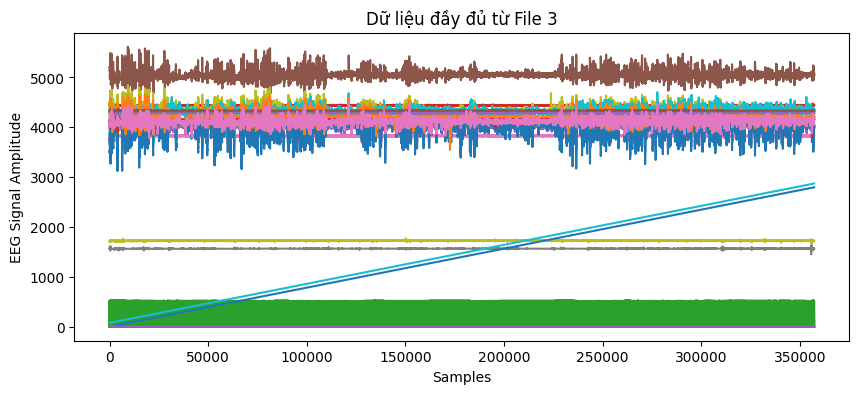


Dữ liệu EEG từ các kênh 4-17: (357224, 14)


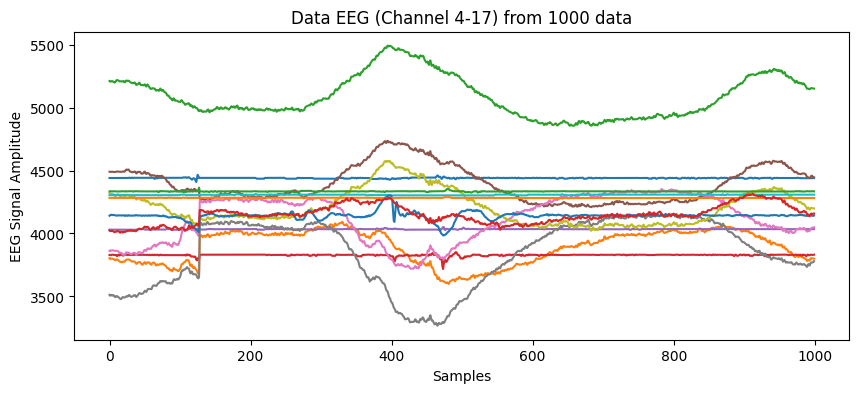

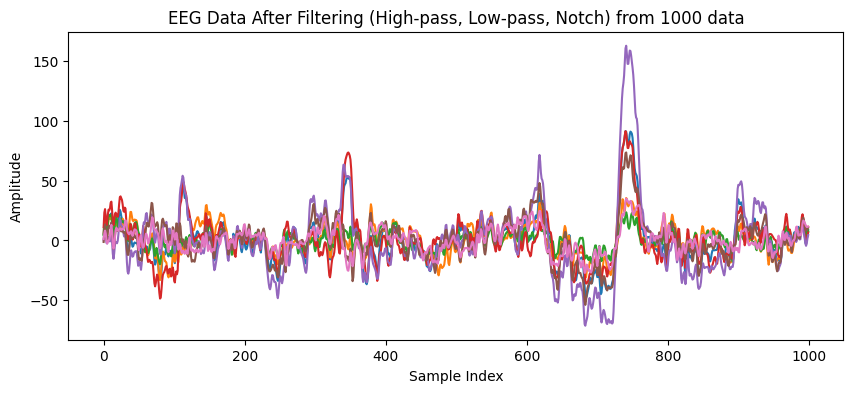

Dữ liệu đầy đủ từ file C:/Users/Phuong/Pattern-Recognition-EEG/Data\eeg_record4.mat: (380344, 25)


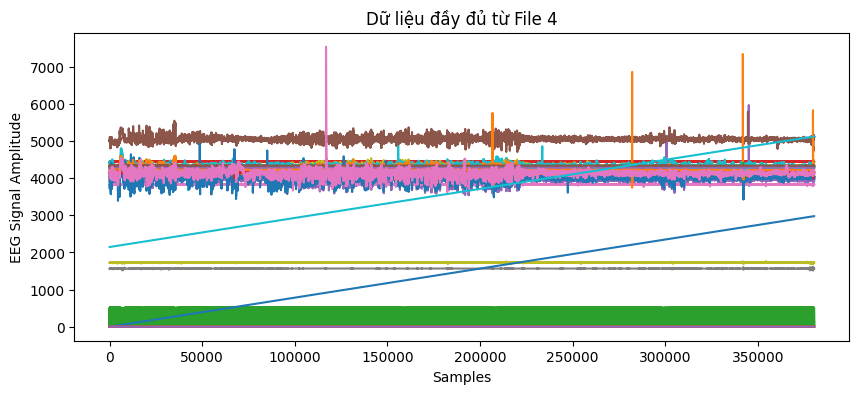


Dữ liệu EEG từ các kênh 4-17: (380344, 14)


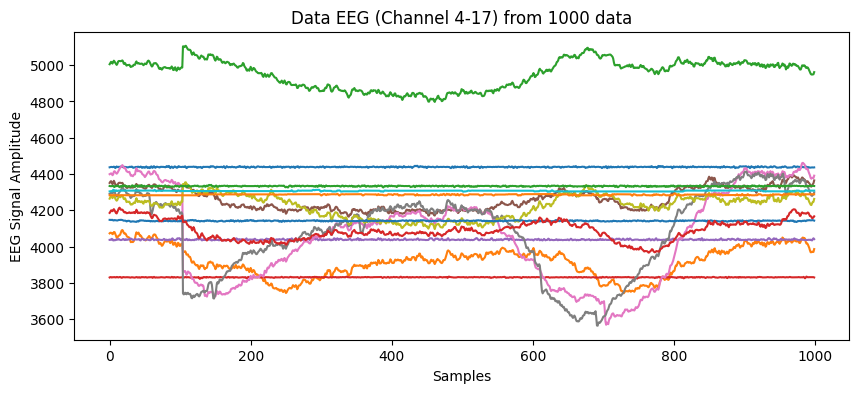

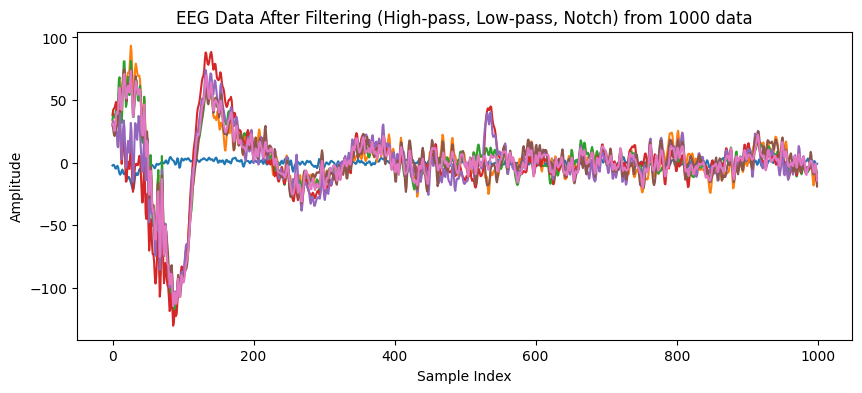

In [43]:
analyze_data(filtered_reduce_data_7channel, file_names, subject_map=subject_map)

In [44]:
def plot_frequency_bands(filtered_data):
    # Định nghĩa các dải tần số
    alpha_low, alpha_high = 8, 13  # Hz
    beta_low, beta_high = 13, 30  # Hz
    delta_low, delta_high = 0.5, 4  # Hz
    theta_low, theta_high = 4, 8  # Hz

    # Lọc thông dải để giữ lại các dải tần số khác nhau
    alpha_band = bandpass_filter(filtered_data, alpha_low, alpha_high, sampFreq)
    beta_band = bandpass_filter(filtered_data, beta_low, beta_high, sampFreq)
    delta_band = bandpass_filter(filtered_data, delta_low, delta_high, sampFreq)
    theta_band = bandpass_filter(filtered_data, theta_low, theta_high, sampFreq)

    # Biểu diễn tín hiệu dải delta
    plt.figure(figsize=(15, 6))
    plt.plot(delta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Delta Band (0.5-4 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải theta
    plt.figure(figsize=(15, 6))
    plt.plot(theta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Theta Band (4-8 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải alpha
    plt.figure(figsize=(15, 6))
    plt.plot(alpha_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Alpha Band (8-13 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()

    # Biểu diễn tín hiệu dải beta
    plt.figure(figsize=(15, 6))
    plt.plot(beta_band[:1000])  # Chỉ hiển thị 1000 mẫu đầu tiên để dễ quan sát
    plt.title('EEG Beta Band (13-30 Hz)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend(channel_names, loc='upper right')
    plt.tight_layout()
    plt.show()


In [45]:
filtered_full_data_7channel[0].shape

(308868, 7)

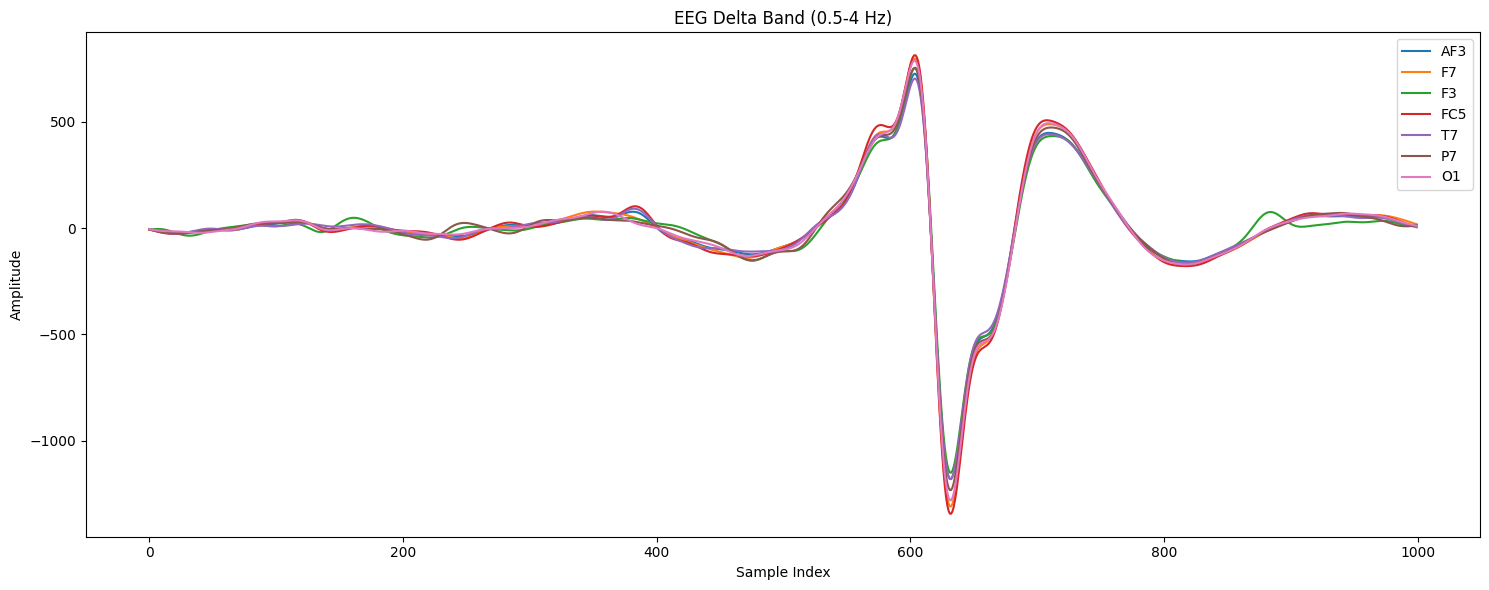

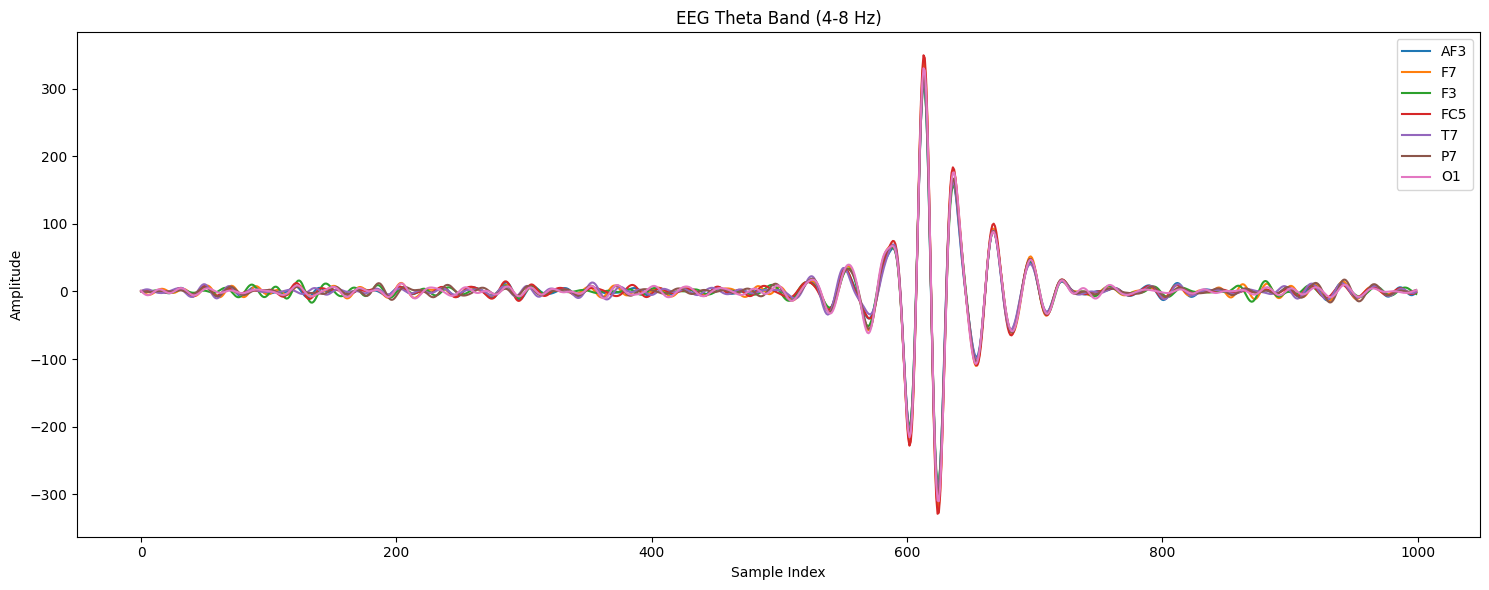

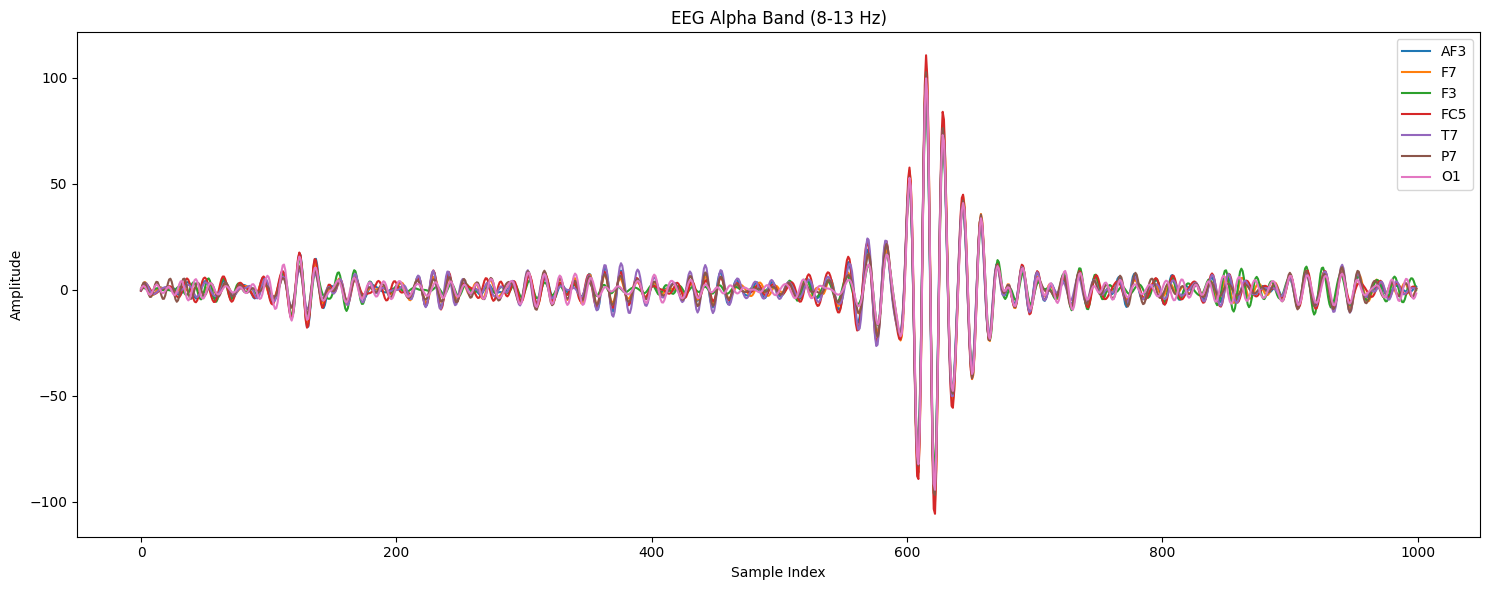

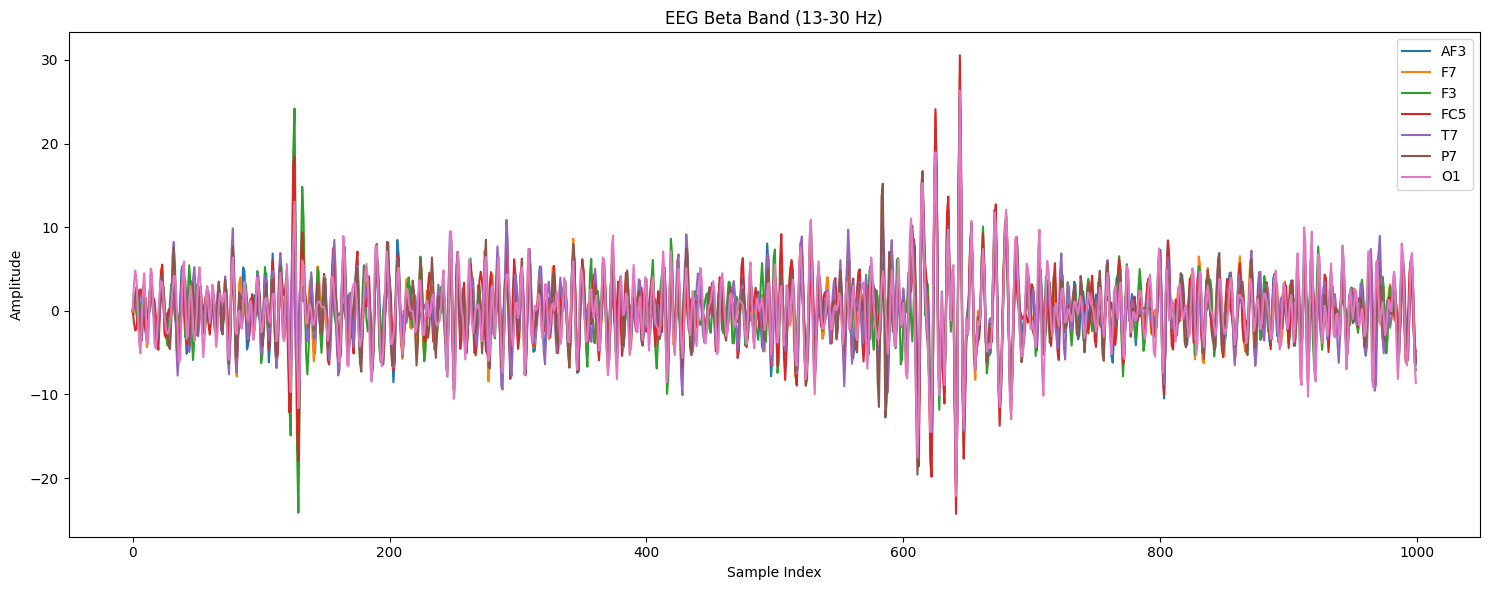

In [46]:
plot_frequency_bands(filtered_full_data_7channel[0])

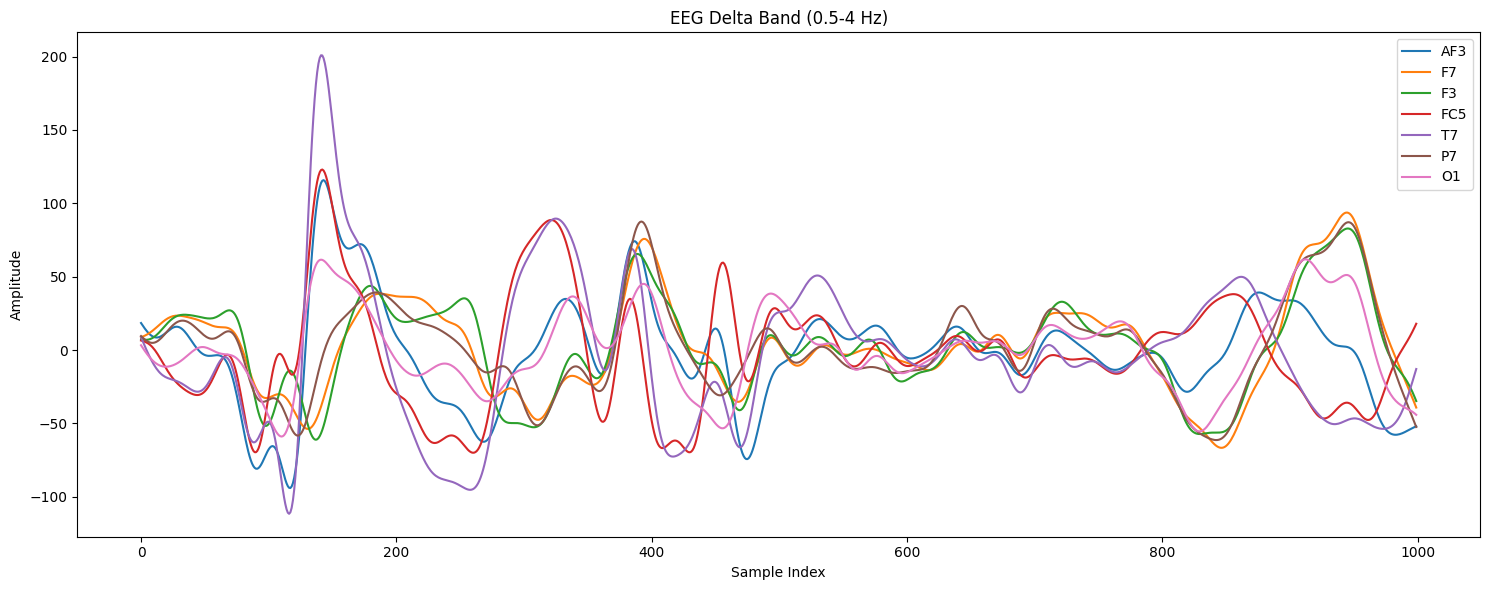

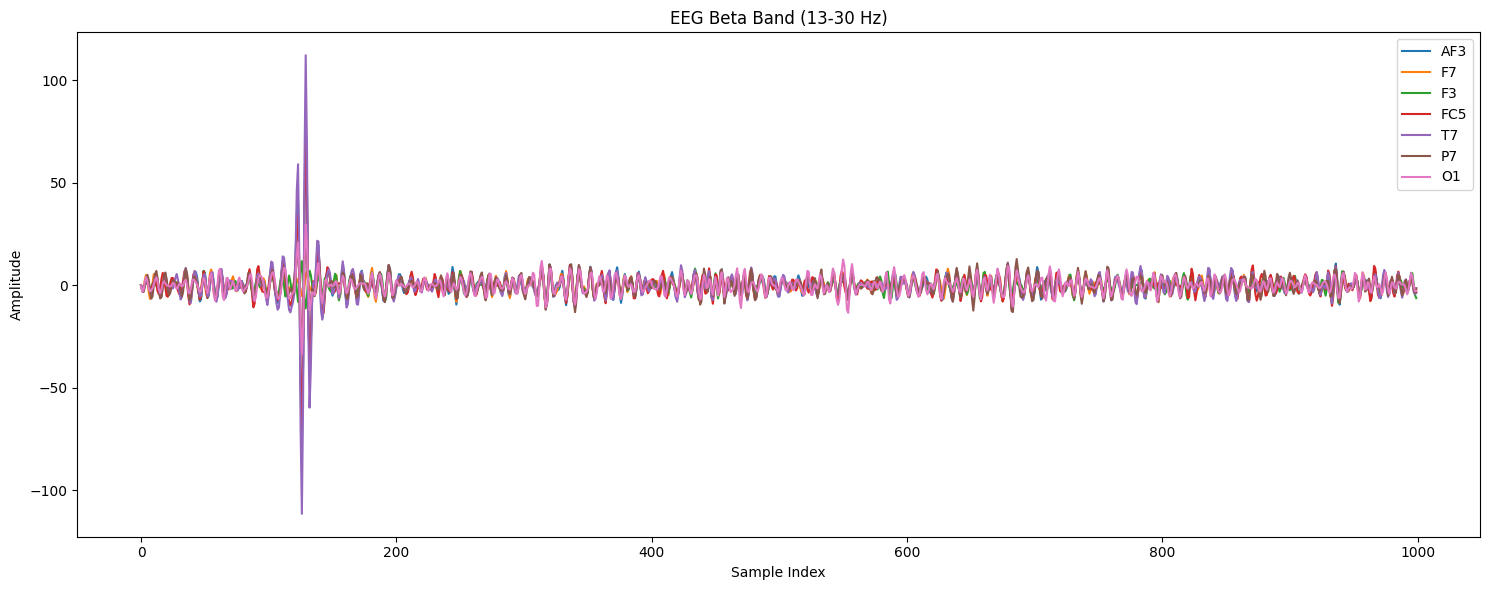

In [47]:
plot_frequency_bands(filtered_reduce_data_7channel[0])

# ICA

In [48]:
import mne
from mne.preprocessing import ICA

def apply_ica_to_data(filtered_data):
    ica_list = []
    raw_list = []

    for i in range(len(filtered_data)):

        data_one_day = filtered_data[i]

        # Tạo thông tin cho đối tượng Raw
        sfreq = 128  # Tần số lấy mẫu (giả sử là 128 Hz, bạn có thể thay đổi nếu khác)
        info = mne.create_info(ch_names=useful_channels_names, sfreq=sfreq, ch_types='eeg')

        # Lấy dữ liệu đã lọc từ danh sách, chuyển đổi thành dạng phù hợp cho MNE
        filtered_data_mne = data_one_day.T  # Chuyển thành (n_channels, n_times)

        # Tạo đối tượng Raw từ dữ liệu
        raw = mne.io.RawArray(filtered_data_mne, info)

        # Thêm montage vào đối tượng Raw với montage 'standard_1020'
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

        # Áp dụng ICA để tách các thành phần độc lập
        ica = ICA(n_components=7, random_state=42, max_iter='auto')
        ica.fit(raw)

        # Lưu ICA và Raw để sử dụng sau
        ica_list.append(ica)
        raw_list.append(raw)

        # In ra thông báo đã xử lý xong
        print(f'Đã áp dụng ICA cho dữ liệu của người thứ {i+1}')

    return ica_list, raw_list

In [49]:
# Áp dụng hàm cho filtered_full_data và filtered_reduce_data
ica_full_data, raw_full_data = apply_ica_to_data(filtered_full_data_7channel)

ica_reduce_data = get_data_5days(ica_full_data)
raw_reduce_data = get_data_5days(raw_full_data)

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 1
Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 2
Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 3
Creating RawArray with float64 data, n_channels=7, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 7 components
Fitting ICA took 3.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 4
Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 5
Creating RawArray with float64 data, n_channels=7, n_times=288752
    Range : 0 ... 288751 =      0.000 ...  2255.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 6
Creating RawArray with float64 data, n_channels=7, n_times=398816
    Range : 0 ... 398815 =      0.000 ...  3115.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 7
Creating RawArray with float64 data, n_channels=7, n_times=365888
    Range : 0 ... 365887 =      0.000 ...  2858.492 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 8
Creating RawArray with float64 data, n_channels=7, n_times=388788
    Range : 0 ... 388787 =      0.000 ...  3037.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 9
Creating RawArray with float64 data, n_channels=7, n_times=381340
    Range : 0 ... 381339 =      0.000 ...  2979.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.4s.
Đã áp dụng ICA cho dữ liệu của người thứ 10
Creating RawArray with float64 data, n_channels=7, n_times=391624
    Range : 0 ... 391623 =      0.000 ...  3059.555 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 11
Creating RawArray with float64 data, n_channels=7, n_times=356728
    Range : 0 ... 356727 =      0.000 ...  2786.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 12
Creating RawArray with float64 data, n_channels=7, n_times=373304
    Range : 0 ... 373303 =      0.000 ...  2916.430 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 13
Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 14
Creating RawArray with float64 data, n_channels=7, n_times=359164
    Range : 0 ... 359163 =      0.000 ...  2805.961 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 15
Creating RawArray with float64 data, n_channels=7, n_times=234372
    Range : 0 ... 234371 =      0.000 ...  1831.023 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 16
Creating RawArray with float64 data, n_channels=7, n_times=443972
    Range : 0 ... 443971 =      0.000 ...  3468.523 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 17
Creating RawArray with float64 data, n_channels=7, n_times=361840
    Range : 0 ... 361839 =      0.000 ...  2826.867 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.9s.
Đã áp dụng ICA cho dữ liệu của người thứ 18
Creating RawArray with float64 data, n_channels=7, n_times=333236
    Range : 0 ... 333235 =      0.000 ...  2603.398 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 19
Creating RawArray with float64 data, n_channels=7, n_times=396812
    Range : 0 ... 396811 =      0.000 ...  3100.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 20
Creating RawArray with float64 data, n_channels=7, n_times=336280
    Range : 0 ... 336279 =      0.000 ...  2627.180 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 0.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 21
Creating RawArray with float64 data, n_channels=7, n_times=324764
    Range : 0 ... 324763 =      0.000 ...  2537.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 22
Creating RawArray with float64 data, n_channels=7, n_times=388088
    Range : 0 ... 388087 =      0.000 ...  3031.930 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 3.3s.
Đã áp dụng ICA cho dữ liệu của người thứ 23
Creating RawArray with float64 data, n_channels=7, n_times=360928
    Range : 0 ... 360927 =      0.000 ...  2819.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 24
Creating RawArray with float64 data, n_channels=7, n_times=415164
    Range : 0 ... 415163 =      0.000 ...  3243.461 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 25
Creating RawArray with float64 data, n_channels=7, n_times=363232
    Range : 0 ... 363231 =      0.000 ...  2837.742 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.5s.
Đã áp dụng ICA cho dữ liệu của người thứ 26
Creating RawArray with float64 data, n_channels=7, n_times=347548
    Range : 0 ... 347547 =      0.000 ...  2715.211 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.1s.
Đã áp dụng ICA cho dữ liệu của người thứ 27
Creating RawArray with float64 data, n_channels=7, n_times=214540
    Range : 0 ... 214539 =      0.000 ...  1676.086 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 28
Creating RawArray with float64 data, n_channels=7, n_times=424608
    Range : 0 ... 424607 =      0.000 ...  3317.242 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.7s.
Đã áp dụng ICA cho dữ liệu của người thứ 29
Creating RawArray with float64 data, n_channels=7, n_times=349008
    Range : 0 ... 349007 =      0.000 ...  2726.617 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.0s.
Đã áp dụng ICA cho dữ liệu của người thứ 30
Creating RawArray with float64 data, n_channels=7, n_times=428848
    Range : 0 ... 428847 =      0.000 ...  3350.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 31
Creating RawArray with float64 data, n_channels=7, n_times=483732
    Range : 0 ... 483731 =      0.000 ...  3779.148 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.6s.
Đã áp dụng ICA cho dữ liệu của người thứ 32
Creating RawArray with float64 data, n_channels=7, n_times=483376
    Range : 0 ... 483375 =      0.000 ...  3776.367 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.8s.
Đã áp dụng ICA cho dữ liệu của người thứ 33
Creating RawArray with float64 data, n_channels=7, n_times=408976
    Range : 0 ... 408975 =      0.000 ...  3195.117 secs
Ready.
Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components


C:\Users\Phuong\AppData\Local\Temp\ipykernel_22908\3803510155.py:28: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 1.2s.
Đã áp dụng ICA cho dữ liệu của người thứ 34


In [50]:
def plot_ica_components(ica_list, raw_list, num_files=2, reduce=False):
    # Nếu giảm dữ liệu, tính toán chỉ số file bắt đầu từ file thứ 3
    if reduce:
        start_index = 2  # Người thứ 1 bắt đầu từ file thứ 3
        step = 7  # Bước nhảy mỗi lần là 7 (người 2 từ file thứ 10, người 3 từ file thứ 17, v.v.)
    else:
        start_index = 0  # Nếu không giảm, bắt đầu từ file thứ 1
        step = 1  # Bước nhảy 1 file mỗi lần

    for i in range(num_files):
        # Tính chỉ số file dựa trên người và kiểu dữ liệu
        file_index = start_index + i * step
        if file_index < len(ica_list):
            print(f'Vẽ các thành phần ICA cho file thứ {file_index + 1}')

            # Vẽ các thành phần ICA
            ica_list[file_index].plot_components()

            # Vẽ tín hiệu của các thành phần ICA với Raw data
            ica_list[file_index].plot_sources(raw_list[file_index], start=0, stop=40, show_scrollbars=False)

            plt.show()

Vẽ các thành phần ICA cho file thứ 1


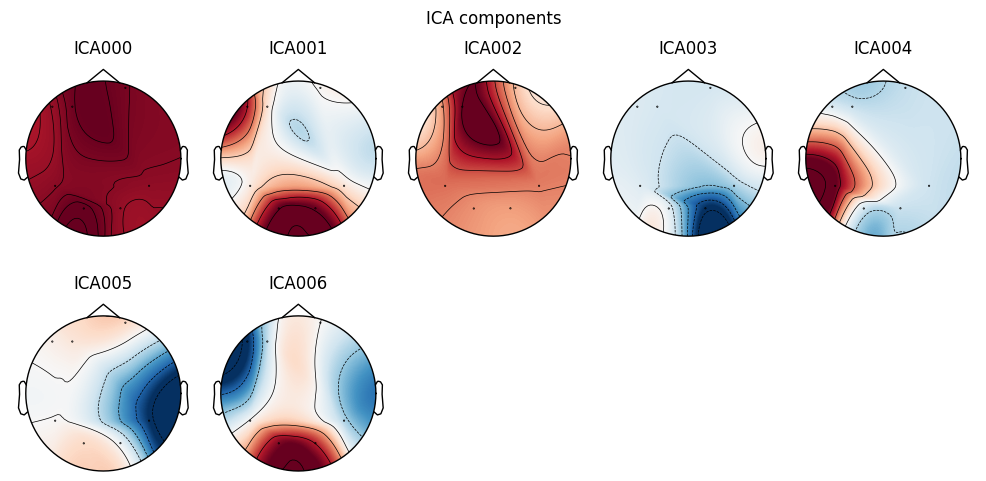

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.
Using matplotlib as 2D backend.


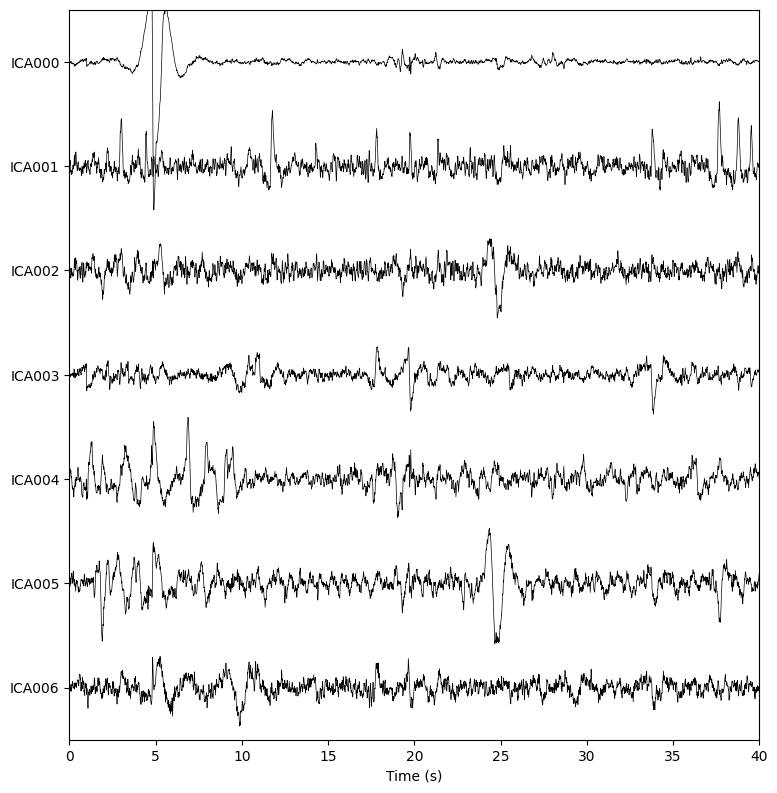

Vẽ các thành phần ICA cho file thứ 2


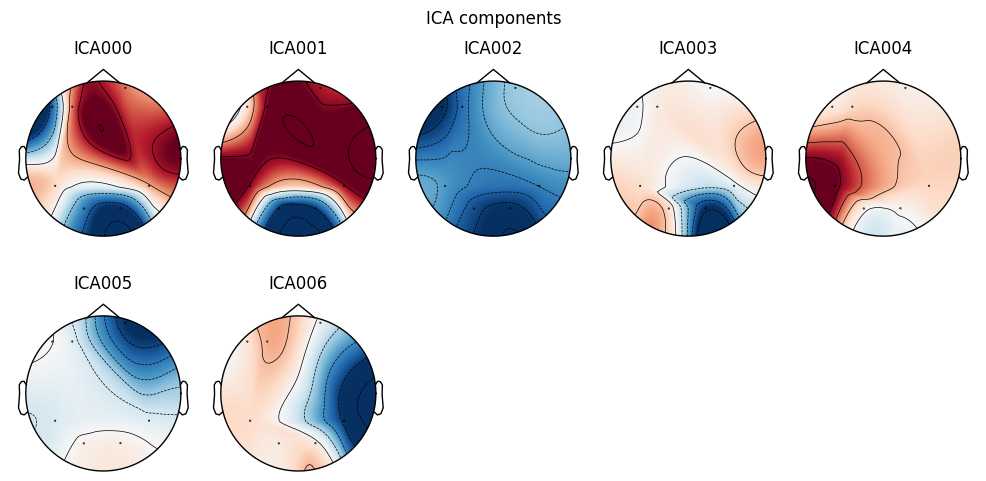

Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.


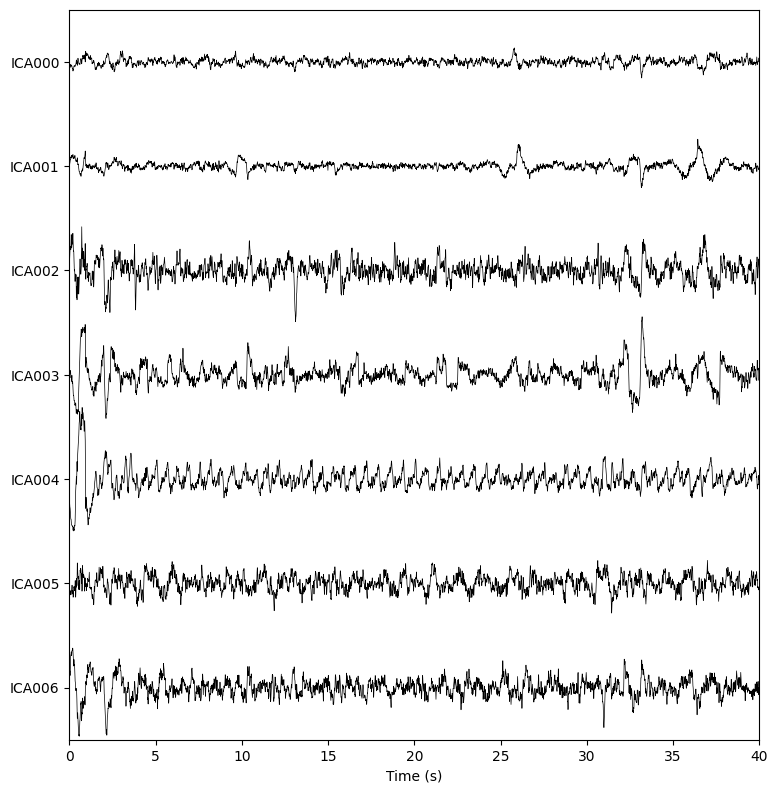

In [51]:
plot_ica_components(ica_full_data, raw_full_data)

Vẽ các thành phần ICA cho file thứ 3


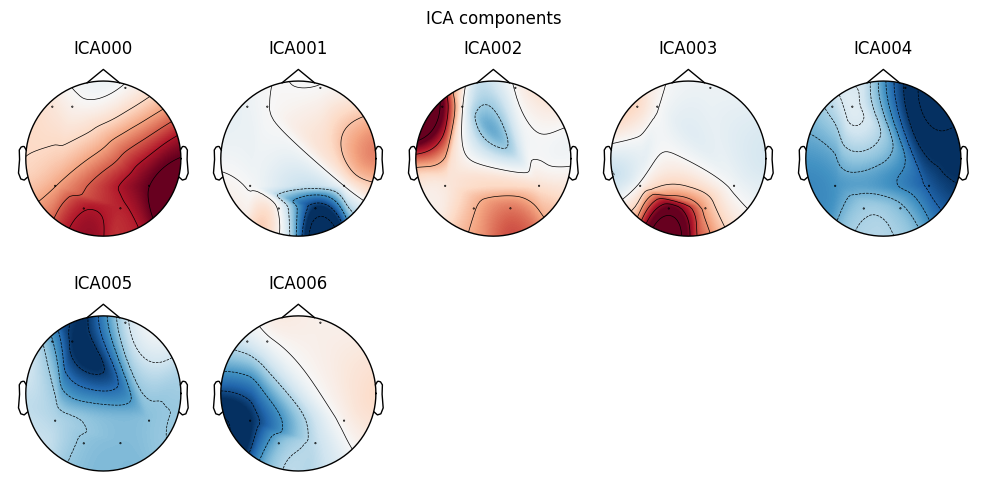

Creating RawArray with float64 data, n_channels=7, n_times=351204
    Range : 0 ... 351203 =      0.000 ...  2743.773 secs
Ready.


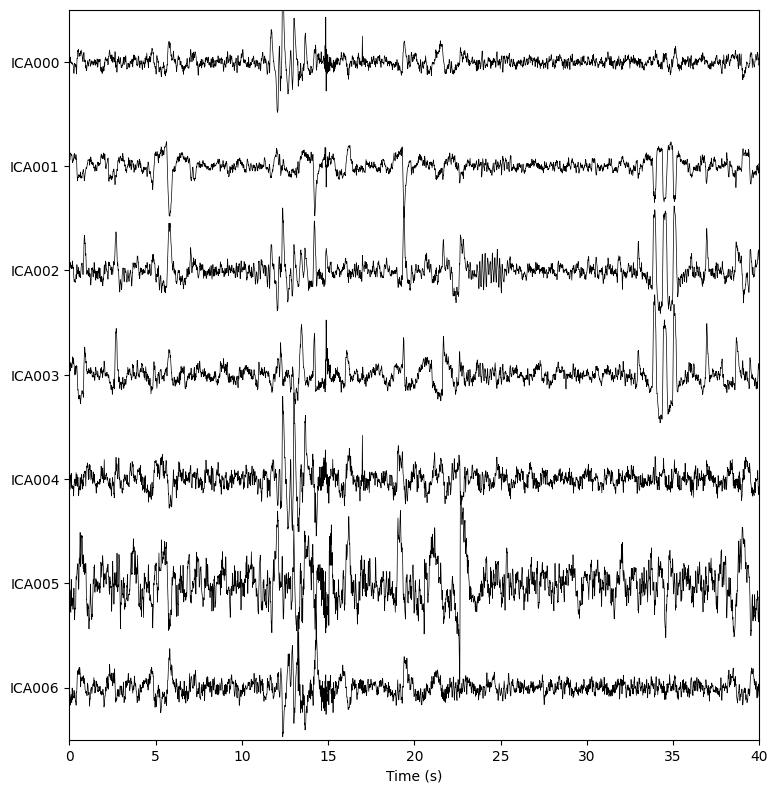

Vẽ các thành phần ICA cho file thứ 10


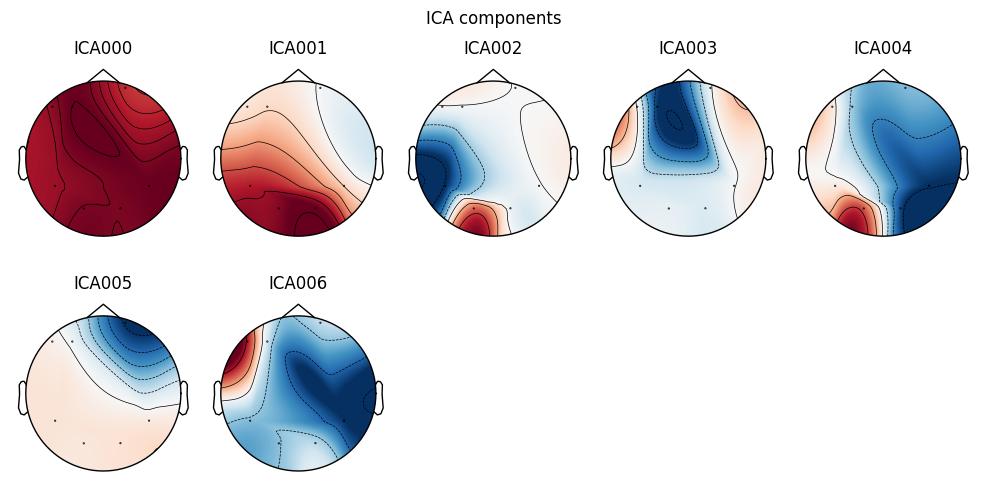

Creating RawArray with float64 data, n_channels=7, n_times=345164
    Range : 0 ... 345163 =      0.000 ...  2696.586 secs
Ready.


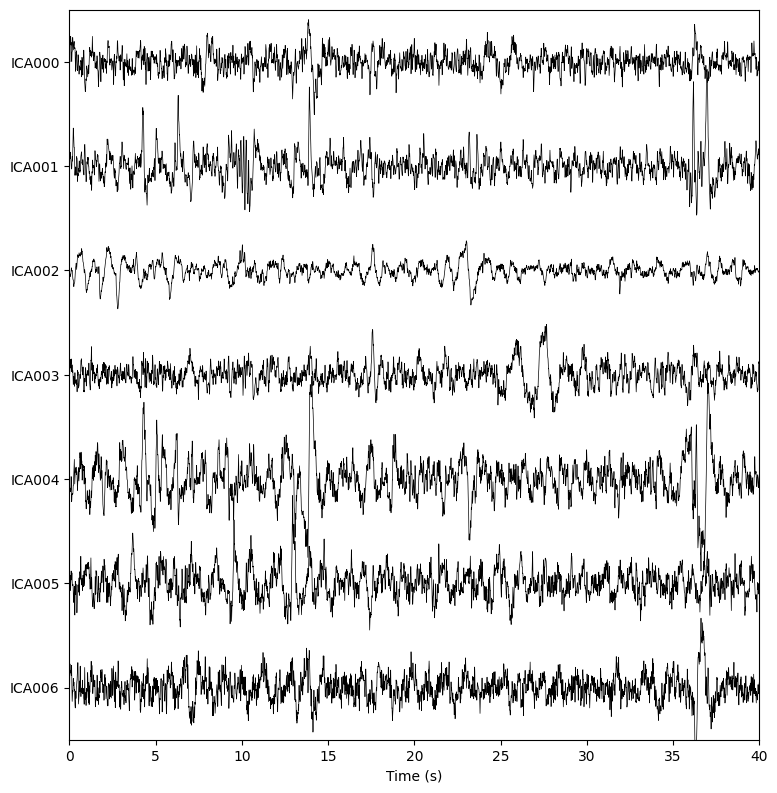

In [52]:
plot_ica_components(ica_reduce_data, raw_reduce_data, num_files=2, reduce=True)

In [53]:
def detect_eog_artifacts(ica, raw, eye_channels):
    all_eog_indices = {}

    for ch in eye_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nháy mắt (EOG)
                eog_indices, _ = ica.find_bads_eog(raw, ch_name=ch)
                all_eog_indices[ch] = eog_indices
                # print(f"Các thành phần ICA liên quan đến nháy mắt với kênh {ch}: {eog_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_eog_indices

def detect_ecg_artifacts(ica, raw, heart_related_channels):
    all_ecg_indices = {}

    for ch in heart_related_channels:
        if ch in raw.ch_names:  # Kiểm tra nếu kênh có tồn tại trong đối tượng Raw
            try:
                # Phát hiện nhiễu nhịp tim (ECG)
                ecg_indices, _ = ica.find_bads_ecg(raw, ch_name=ch)
                all_ecg_indices[ch] = ecg_indices
                # print(f"Các thành phần ICA liên quan đến nhịp tim với kênh {ch}: {ecg_indices}")
            except Exception as e:
                print(f"Lỗi khi chạy với kênh {ch}: {e}")

    return all_ecg_indices

def print_indices_results(all_eog_indices, all_ecg_indices):
    # In kết quả EOG
    print("\nKết quả từ tất cả các kênh EOG:")
    for ch, indices in all_eog_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")

    # In kết quả ECG
    print("\nKết quả từ tất cả các kênh ECG:")
    for ch, indices in all_ecg_indices.items():
        print(f"Kênh {ch}: Thành phần ICA {indices}")

In [54]:
def detect_artifacts(ica_list, raw_list):
    # Danh sách các kênh bị ảnh hưởng nhiễu từ mắt và tim
    eye_channels = ['F7']
    heart_channels = ['F7']

    eog_indices = []
    ecg_indices = []

    # Duyệt qua từng file trong raw_list và ica_list
    for i in range(len(raw_list)):
        print(f"\nKết quả cho file #{i + 1}:")
        
        # Phát hiện nhiễu EOG và ECG cho từng file
        eog = detect_eog_artifacts(ica_list[i], raw_list[i], eye_channels)
        ecg = detect_ecg_artifacts(ica_list[i], raw_list[i], heart_channels)

        eog_indices.append(eog)
        ecg_indices.append(ecg)


    return eog_indices, ecg_indices

In [55]:
eog_indices_full, ecg_indices_full = detect_artifacts(ica_full_data, raw_full_data)


Kết quả cho file #1:
Using EOG channel: F7
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff fr

In [56]:
eog_indices_reduce = get_data_5days(eog_indices_full)
ecg_indices_reduce = get_data_5days(ecg_indices_full)

In [57]:
def get_artifacts_table(eog_indices, ecg_indices, data_type="EOG"):
    
    # Khởi tạo danh sách các kênh
    channels = ['F7','F3','P7','O1','O2','P8','AF4']

    # Dữ liệu sẽ chứa thông tin từng chỉ số ICA bị nhiễu cho các kênh
    artifact_data = {channel: [] for channel in channels}

    # Duyệt qua từng file để lấy các chỉ số ICA nhiễu
    for artifact in (eog_indices if data_type == "EOG" else ecg_indices):
        for channel in channels:
            # Lấy các thành phần ICA bị nhiễu cho kênh này
            artifact_data[channel].append(artifact.get(channel, []))

    # Chuyển thành DataFrame
    artifact_df = pd.DataFrame(artifact_data)

    # Trả về bảng kết quả
    return artifact_df.transpose()  # Trả về DataFrame với mỗi file là một cột

# In kết quả EOG - Dữ liệu đầy đủ
eog_full_df = get_artifacts_table(eog_indices_full, ecg_indices_full, data_type="EOG")
print("Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu đầy đủ:")
print(eog_full_df)

# In kết quả EOG - Dữ liệu giảm
eog_reduce_df = get_artifacts_table(eog_indices_reduce, ecg_indices_reduce, data_type="EOG")
print("\nCác chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu giảm:")
print(eog_reduce_df)

# In kết quả ECG - Dữ liệu đầy đủ
ecg_full_df = get_artifacts_table(eog_indices_full, ecg_indices_full, data_type="ECG")
print("\nCác chỉ số ICA bị nhiễu tim (ECG) - Dữ liệu đầy đủ:")
print(ecg_full_df)

# In kết quả ECG - Dữ liệu giảm
ecg_reduce_df = get_artifacts_table(eog_indices_reduce, ecg_indices_reduce, data_type="ECG")
print("\nCác chỉ số ICA bị nhiễu tim (ECG) - Dữ liệu giảm:")
print(ecg_reduce_df)

Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu đầy đủ:
     0   1   2   3   4   5   6   7   8   9   ...  24  25  26  27  28  29  30  \
F7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
F3   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P7   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O1   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
O2   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
P8   []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   
AF4  []  []  []  []  []  []  []  []  []  []  ...  []  []  []  []  []  []  []   

     31  32  33  
F7   []  []  []  
F3   []  []  []  
P7   []  []  []  
O1   []  []  []  
O2   []  []  []  
P8   []  []  []  
AF4  []  []  []  

[7 rows x 34 columns]

Các chỉ số ICA bị nhiễu mắt (EOG) - Dữ liệu giảm:
     0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  19  20  \
F7   []  

In [58]:
def exclude_ica_components_for_all(ica_list, raw_list, eog_indices_list, ecg_indices_list):

    excluded_raw_list = []
    excluded_ica_list = []

    for idx, ica in enumerate(ica_list):
        print(f"\nĐang loại bỏ thành phần ICA cho file #{idx + 1}:")
        
        # Lấy chỉ số EOG và ECG cho từng file
        eog_indices = eog_indices_list[idx]
        ecg_indices = ecg_indices_list[idx]
        
        # Tạo bản sao của raw để giữ dữ liệu gốc và dữ liệu đã loại trừ riêng biệt
        raw_copy = raw_list[idx].copy()

        # Loại bỏ các thành phần ICA cho EOG và ECG
        all_exclude_indices = []
        
        # Thêm các thành phần ICA bị nhiễu EOG và ECG vào danh sách loại trừ
        for eog in eog_indices.values():  # Duyệt qua các chỉ số EOG
            all_exclude_indices.extend(eog)
        
        for ecg in ecg_indices.values():  # Duyệt qua các chỉ số ECG
            all_exclude_indices.extend(ecg)
        
        # Loại bỏ các thành phần ICA trong ica.exclude
        ica.exclude = list(set(all_exclude_indices))  # Loại bỏ trùng lặp
        print(f"Đã loại bỏ các thành phần ICA: {ica.exclude}")
        
        # Áp dụng ICA sau khi loại trừ
        ica.apply(raw_copy)  # Áp dụng loại trừ vào bản sao của raw

        # Thêm dữ liệu đã loại trừ vào danh sách kết quả
        excluded_raw_list.append(raw_copy)
        excluded_ica_list.append(ica)  # Lưu lại đối tượng ICA đã loại trừ

        print(f"Đã loại trừ thành công cho file #{idx + 1}")
    
    return excluded_ica_list ,excluded_raw_list

# Sử dụng với dữ liệu đầy đủ (full_data) và dữ liệu giảm (reduce_data)
excluded_ica_full, excluded_raw_full = exclude_ica_components_for_all(ica_full_data, raw_full_data, eog_indices_full, ecg_indices_full)

# excluded_raw_reduce_data = exclude_ica_components_for_all(ica_reduce_data, raw_reduce_data, eog_indices_reduce, ecg_indices_reduce)
excluded_ica_reduce = get_data_5days(excluded_ica_full)
excluded_raw_reduce = get_data_5days(excluded_raw_full)


Đang loại bỏ thành phần ICA cho file #1:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #1

Đang loại bỏ thành phần ICA cho file #2:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #2

Đang loại bỏ thành phần ICA cho file #3:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA components
Đã loại trừ thành công cho file #3

Đang loại bỏ thành phần ICA cho file #4:
Đã loại bỏ các thành phần ICA: []
Applying ICA to Raw instance
    Transforming to ICA space (7 components)
    Zeroing out 0 ICA components
    Projecting back using 7 PCA co

Vẽ các thành phần ICA cho file thứ 1


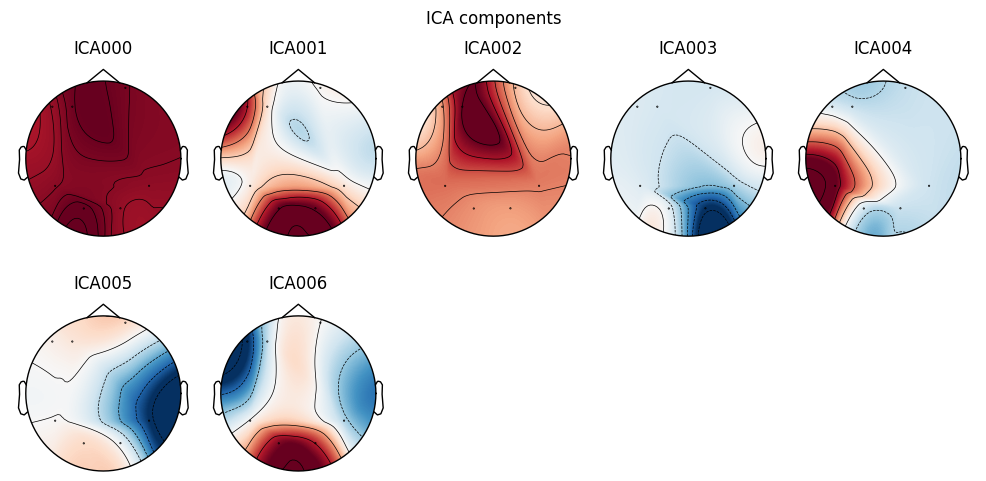

Creating RawArray with float64 data, n_channels=7, n_times=308868
    Range : 0 ... 308867 =      0.000 ...  2413.023 secs
Ready.


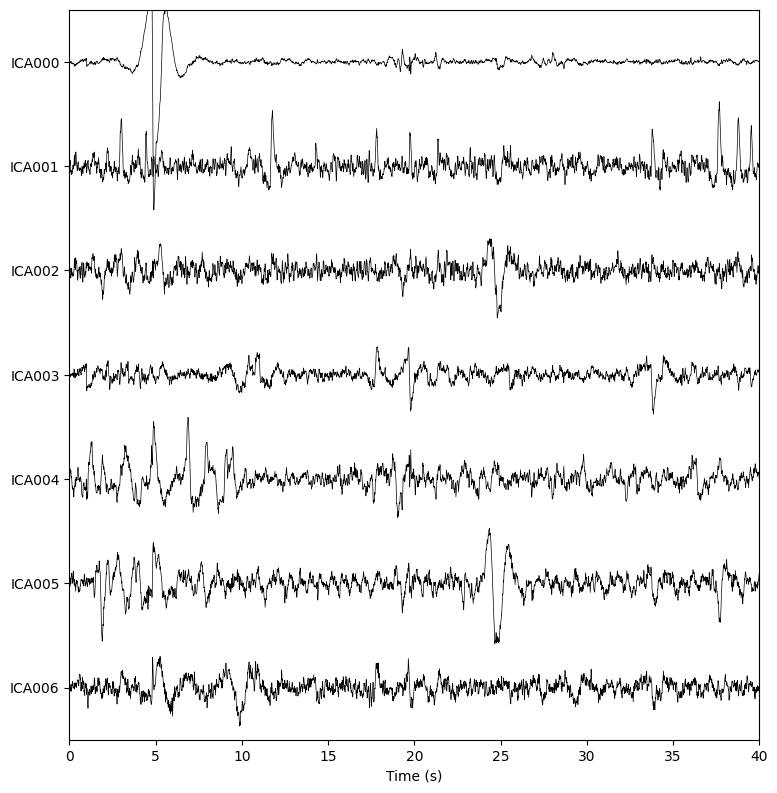

Vẽ các thành phần ICA cho file thứ 2


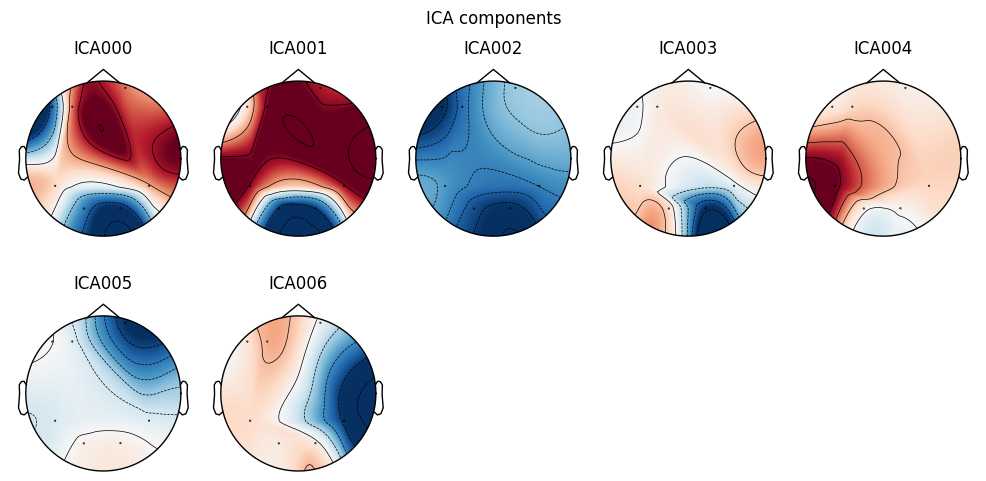

Creating RawArray with float64 data, n_channels=7, n_times=366020
    Range : 0 ... 366019 =      0.000 ...  2859.523 secs
Ready.


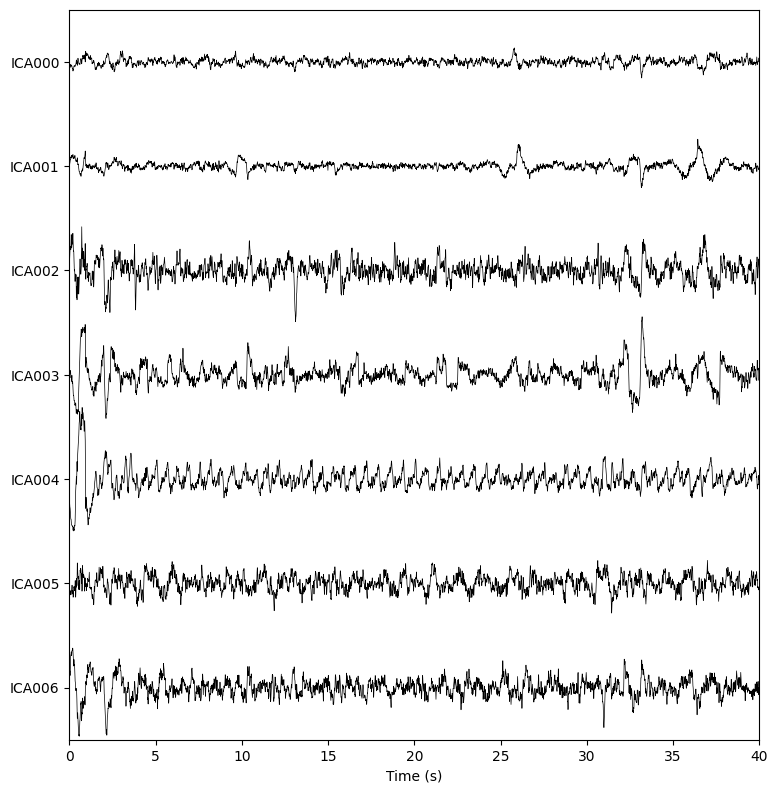

In [59]:
plot_ica_components(ica_full_data, raw_full_data)

Vẽ các thành phần ICA cho file thứ 1


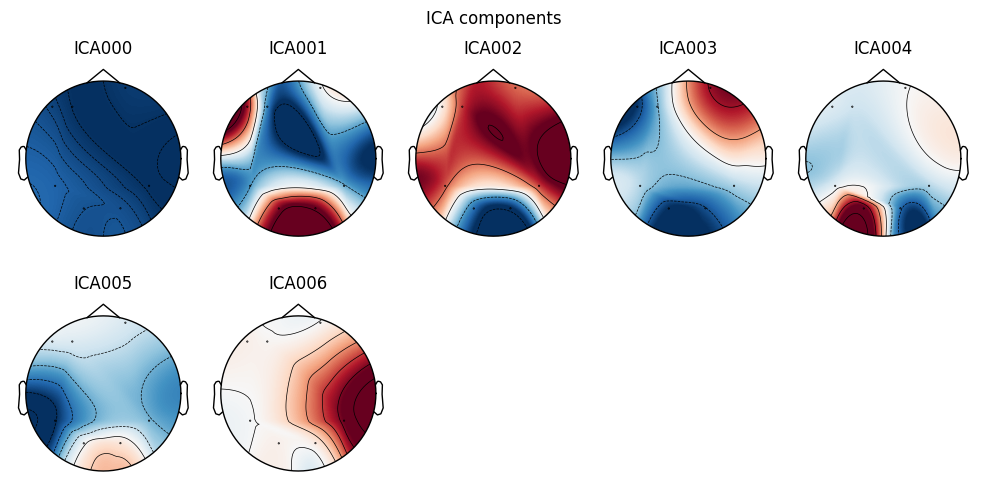

Creating RawArray with float64 data, n_channels=7, n_times=357224
    Range : 0 ... 357223 =      0.000 ...  2790.805 secs
Ready.


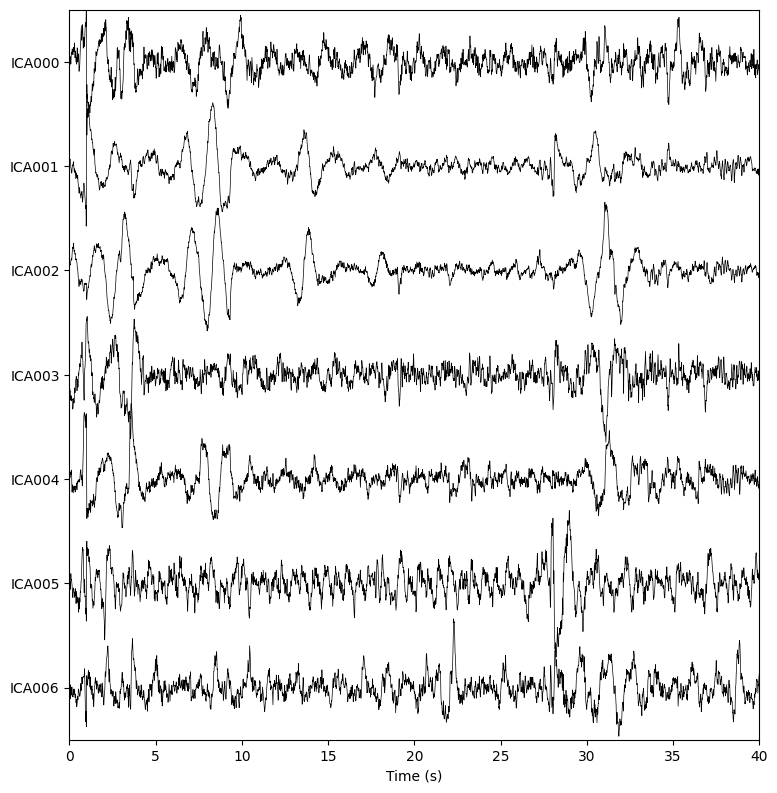

Vẽ các thành phần ICA cho file thứ 2


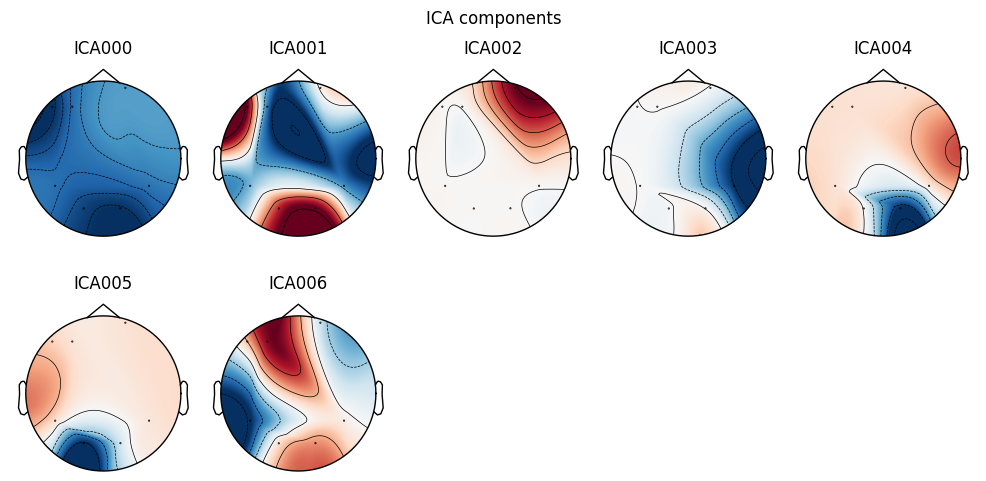

Creating RawArray with float64 data, n_channels=7, n_times=380344
    Range : 0 ... 380343 =      0.000 ...  2971.430 secs
Ready.


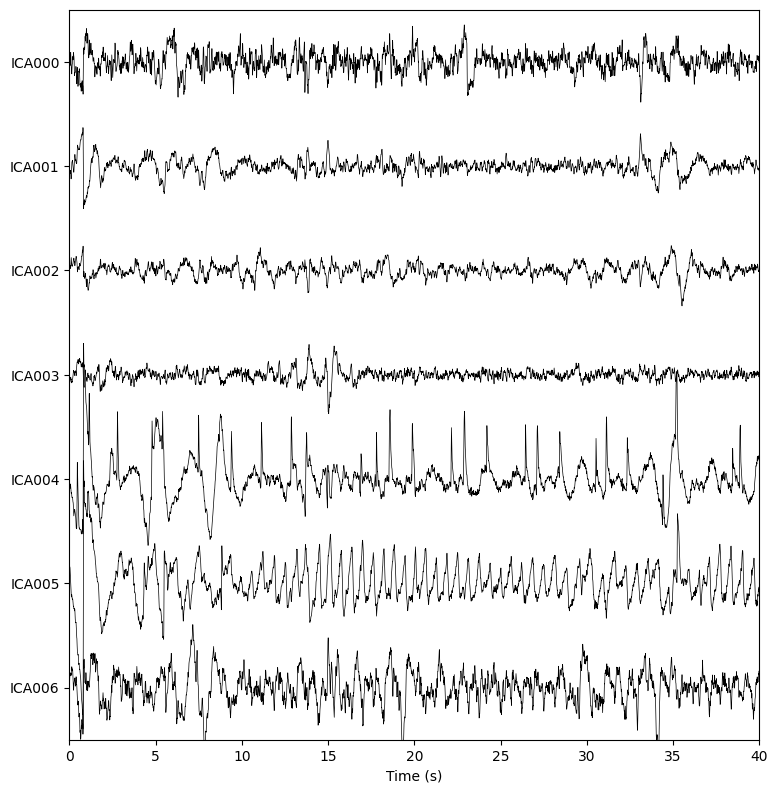

In [60]:
plot_ica_components(ica_reduce_data, raw_reduce_data)

In [61]:
# Lưu dữ liệu vào một dictionary với keys là 'file_1', 'file_2', ...
full_data_ICA = {}
reduce_data_ICA = {}

for idx, raw in enumerate(excluded_raw_full):
    file_key = f"file_{idx + 1}"  # Key cho từng file (file_1, file_2, ...)
    full_data_ICA[file_key] = raw.get_data().T  # Lưu dữ liệu của file vào dictionary

for idx, raw in enumerate(excluded_raw_reduce):
    file_key = f"file_{idx + 1}"  # Key cho từng file (file_1, file_2, ...)
    reduce_data_ICA[file_key] = raw.get_data().T  # Lưu dữ liệu của file vào dictionary

In [62]:
# In thử data của 1 file 
full_data_ICA['file_1']

array([[ 6.5704718 ,  4.07116275,  4.02036303, ...,  5.8181092 ,
         4.35043241,  6.42530974],
       [ 7.64045221,  3.33447359,  7.03013087, ...,  7.03656794,
         5.27359698,  8.16527919],
       [ 7.45826234,  2.11681037,  6.14721954, ...,  7.4153467 ,
         5.87179032,  6.53676772],
       ...,
       [20.24355726, 16.17077115, 20.79365861, ..., 20.82856987,
         3.73162805, 15.26894104],
       [19.27838229, 15.29511576, 17.05681157, ..., 19.38353119,
         5.30686234, 14.85789885],
       [15.88845725, 15.10874378, 11.93877583, ..., 16.63743158,
        13.00576215, 16.17590883]])

In [63]:
full_data_ICA['file_1'].shape

(308868, 7)

In [64]:
reduce_data_ICA

{'file_1': array([[24.1974972 ,  6.00084406,  4.23830338, ..., 16.96838111,
         10.22124612,  1.91832998],
        [19.7212799 ,  2.85110055,  3.29300673, ..., 14.33737554,
          5.44073456, -3.05514875],
        [19.06793926,  3.39232986,  3.41850969, ..., 12.97791361,
          3.86129933, -3.88041594],
        ...,
        [12.42305188, 18.81125479,  7.11168582, ..., 13.91258821,
         12.92372267,  6.00828526],
        [ 8.8658258 , 14.07675821,  6.68788509, ..., 11.32867891,
         10.06841613,  4.72079507],
        [ 2.85255593,  5.58936839,  2.624822  , ...,  1.51582002,
          5.10406494,  3.4232087 ]]),
 'file_2': array([[ -6.75091575,   0.97402046,  -4.83068232, ..., -10.81059779,
           6.20316664,  -5.97235385],
        [ -2.5490826 ,   9.80281066,   3.9201258 , ...,  -5.83730206,
          17.65620763,   2.08026867],
        [ -2.23339934,  12.19591823,   4.22821809, ...,  -2.70794098,
          21.10909504,   6.31305382],
        ...,
        [  6.680

# Extract

In [65]:
def restructure_data(reduce_data_ICA, fs=128):
    # Tạo từ điển để lưu trữ dữ liệu
    data_dict = {
        'Focused': {},
        'Unfocused': {},
        'Drowsy': {}
    }
 
    # Định nghĩa số mẫu cho mỗi khoảng thời gian
    samples_per_minute = fs * 60  # Số mẫu trong 1 phút
    samples_10_minutes = samples_per_minute * 10  # Số mẫu trong 10 phút
    samples_20_minutes = samples_per_minute * 20  # Số mẫu trong 20 phút

    # Chia dữ liệu cho từng người và từng trạng thái
    for file_key, data in reduce_data_ICA.items():
        # Kiểm tra có file không
        if file_key not in reduce_data_ICA:
            continue

        # Chia dữ liệu thành 3 phần: focused, unfocused, drowsy
        focus_data = data[:samples_10_minutes, :]
        unfocus_data = data[samples_10_minutes:samples_10_minutes * 2, :]
        drowsy_data = data[samples_10_minutes * 2:, :]

        # Lưu trữ dữ liệu cho các trạng thái
        if 'file' in file_key:
            subject_key = file_key  # Sử dụng tên file làm key
            data_dict['Focused'][subject_key] = focus_data
            data_dict['Unfocused'][subject_key] = unfocus_data
            data_dict['Drowsy'][subject_key] = drowsy_data

    return data_dict


In [66]:
data_dict = restructure_data(reduce_data_ICA)

In [67]:
data_dict['Drowsy']['file_1'].shape

(203624, 7)

In [68]:
from scipy.signal import stft

# 1. Hàm tạo cửa sổ Blackman-Harris
def blackman_harris_window(M=128):
    t_win = np.arange(0, M)
    window_blackman = 0.42 - 0.5 * np.cos((2 * np.pi * t_win) / (M - 1)) + 0.08 * np.cos((4 * np.pi * t_win) / (M - 1))
    return window_blackman

# 2. Hàm tính STFT và công suất phổ
def compute_stft_power(data, fs, window, nperseg, nfft=1024):
    f, t, Zxx = stft(data, fs=fs, window=window, nperseg=nperseg, noverlap=0, nfft=nfft,
                     detrend=False, return_onesided=True, boundary='zeros', padded=True)
    power = (np.abs(Zxx)) ** 2
    # Thêm chiều kênh nếu chỉ có 2 chiều (Đảm bảo kết quả có 3 chiều: num_channels, num_frequencies, num_segments)
    return power[np.newaxis, :, :] if power.ndim == 2 else power

# 3. Hàm tính trung bình dải tần 0.5Hz
def average_power_by_band(power, fs, bands):
    if len(power.shape) < 3:
        raise ValueError("Input 'power' phải có ít nhất 3 chiều: (num_channels, num_frequencies, num_segments)")

    num_channels, num_frequencies, num_segments = power.shape
    
    freqs = np.linspace(0, fs / 2, num_frequencies)  # Các tần số tương ứng với các bin
    band_power = np.zeros((num_channels, len(bands), num_segments))

    for band_idx, (band_name, (low_freq, high_freq)) in enumerate(bands.items()):
        # Xác định chỉ số các tần số trong khoảng dải tần
        band_indices = np.where((freqs >= low_freq) & (freqs < high_freq))[0]
        if len(band_indices) == 0:
            raise ValueError(f"Không tìm thấy frequency bins cho dải tần số {band_name}. Kiểm tra phạm vi dải tần số.")
        # Tính trung bình trên các chỉ số dải tần
        band_power[:, band_idx, :] = np.mean(power[:, band_indices, :], axis=1)

    return band_power

# 4. Hàm tính trung bình di động trên cửa sổ 15 giây
def moving_average_window(data, window_size=15):
    num_segments = data.shape[2] - window_size + 1
    averaged_data = np.zeros((data.shape[0], data.shape[1], num_segments))
    for chn in range(data.shape[0]):
        for j in range(num_segments):
            averaged_data[chn, :, j] = np.average(data[chn, :, j:j + window_size], axis=1)
    return averaged_data

# 5. Hàm chuyển đổi dữ liệu thành vector đặc trưng
def create_model_features(power_ave):
    num_channels, num_bins, num_segments = power_ave.shape

    model_features = np.zeros((num_channels * num_bins, num_segments))
    for j in range(num_segments):
        model_features[:, j] = power_ave[:, :, j].reshape(-1)

    # Áp dụng logarit cho dữ liệu
    model_features = 10 * np.log(model_features)
    return model_features

# 6. Hàm trích xuất đặc trưng từ dữ liệu
def extract_features(data_dict, fs=128, nperseg=128, window_size=15):
    trail_names = list(data_dict['Focused'].keys())
    window = blackman_harris_window(M=nperseg)
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}

    # Khởi tạo từ điển để lưu các đặc trưng
    state_data = {'Focused': {}, 'Unfocused': {}, 'Drowsy': {}}

    for state in state_data.keys():
        for name in trail_names:
            # Tính STFT và công suất phổ
            state_power = [
                compute_stft_power(data_dict[state][name][:, i], fs, window, nperseg)
                for i in range(data_dict[state][name].shape[1])
            ]
            # Ghép các phân đoạn thành một mảng
            state_power = np.concatenate(state_power, axis=0)
            # Tính công suất trung bình theo dải tần
            state_bin = average_power_by_band(state_power, fs, bands)
            # Trung bình di động
            state_ave = moving_average_window(state_bin, window_size=window_size)
            # Chuyển đổi thành vector đặc trưng
            state_data[state][name] = create_model_features(state_ave)

    return (
        state_data['Focused'],
        state_data['Unfocused'],
        state_data['Drowsy']
    )

In [69]:
import copy

def trim_data(data_dict, fs=128, minutes_drowsy=15):
    # Tạo bản sao của data_dict để tránh thay đổi dữ liệu gốc
    data_dict_copy = copy.deepcopy(data_dict)

    # Số dòng tương ứng với thời gian drowsy
    num_rows = fs * minutes_drowsy * 60  # 15 phút (hoặc bạn có thể thay đổi minutes_drowsy)

    # Duyệt qua tất cả các file trong 'Drowsy' và cắt dữ liệu
    for file_key, data in data_dict_copy['Drowsy'].items():
        # Cắt dữ liệu chỉ lấy số dòng đến num_rows
        data_dict_copy['Drowsy'][file_key] = data[:num_rows, :]

    # Trả về data_dict đã thay đổi (bản sao)
    return data_dict_copy

In [70]:
data_dict['Drowsy']['file_3'].shape

(197604, 7)

In [71]:
# Giả sử model_data_drowsy là dictionary dữ liệu của bạn
data_dict_new = trim_data(data_dict)
data_dict_new['Drowsy']['file_3'].shape

(115200, 7)

In [72]:
from collections import Counter
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# New new

In [73]:
data_focus, data_unfocus, data_drowsy = extract_features(data_dict_new)

In [74]:
# Hàm tách dữ liệu theo từng subject (4 để train, 1 để test)
def split_data_state(data_state, subject):
    # Tạo các dictionary chứa dữ liệu
    training_data = {}
    testing_data = {}


    # Tính chỉ số file bắt đầu và kết thúc cho mỗi người
    start_file_idx = (subject - 1 ) + (subject - 1) * 4
    num_files = 5 if subject != 5 else 4  # Người thứ 5 chỉ có 4 file

    # Lấy file cuối cùng cho testing (để kiểm tra)
    last_file_idx = start_file_idx + num_files - 1
    last_file_key = f"file_{last_file_idx + 1}"
    testing_data[last_file_key] = data_state[last_file_key]

    # Các file còn lại cho training (huấn luyện)
    for file_idx in range(start_file_idx, start_file_idx + num_files - 1):  # Bỏ qua file cuối
        file_key = f"file_{file_idx + 1}"
        training_data[file_key] = data_state[file_key]

    return training_data, testing_data


In [75]:
# Hàm kết hợp dữ liệu và tạo nhãn cho từng trạng thái
def combine_data_with_labels(data_focus, data_unfocus, data_drowsy):
    # Lấy tất cả các tên đối tượng
    all_subjects = list(data_focus.keys())

    # Kết hợp dữ liệu của các trạng thái Not-Drowsy (Focused và Unfocused)
    X_focus = np.concatenate([data_focus[subject] for subject in all_subjects], axis=1)
    X_unfocus = np.concatenate([data_unfocus[subject] for subject in all_subjects], axis=1)
    X_drowsy = np.concatenate([data_drowsy[subject] for subject in all_subjects], axis=1)

    # Ghép tất cả các dữ liệu lại
    X = np.concatenate([X_focus, X_unfocus, X_drowsy], axis=1).T  # Chuyển vị để có dạng (n_samples, n_features)

    # Tạo nhãn cho từng trạng thái
    y_focus = ['Focused'] * X_focus.shape[1]  # Nhãn 'Focused' cho trạng thái Focused
    y_unfocus = ['Unfocused'] * X_unfocus.shape[1]  # Nhãn 'Unfocused' cho trạng thái Unfocused
    y_drowsy = ['Drowsy'] * X_drowsy.shape[1]  # Nhãn 'Drowsy' cho trạng thái Drowsy

    # Ghép tất cả các nhãn lại
    y = np.array(y_focus + y_unfocus + y_drowsy)

    return X, y

In [76]:
def train_test_model(data_focus, data_unfocus, data_drowsy, subject):
    train_focused, test_focused = split_data_state(data_focus, subject)
    train_unfocused, test_unfocused = split_data_state(data_unfocus, subject)
    train_drowsy, test_drowsy = split_data_state(data_drowsy, subject)


    X_train, y_train = combine_data_with_labels(train_focused, train_unfocused, train_drowsy)
    X_test, y_test = combine_data_with_labels(test_focused, test_unfocused, test_drowsy)

    return X_train, X_test, y_train, y_test

In [77]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=1)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=2)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=3)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=4)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_model(data_focus, data_unfocus, data_drowsy, subject=5)

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix for predictions.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="horizontal")
    plt.title("Confusion Matrix")
    plt.show()

**Object 1** 

In [78]:
# Đếm số lượng từng nhãn
label_counts = Counter(y_train_1)

# Tạo DataFrame từ Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused   2348
1  Unfocused   2348
2     Drowsy   3548


In [79]:
# Chuẩn hóa dữ liệu
scaler_1 = StandardScaler()
X_train_scaled_1 = scaler_1.fit_transform(X_train_1)  # Fit và transform trên tập train
X_test_scaled_1 = scaler_1.transform(X_test_1)        # Chỉ transform trên tập test

Báo cáo đánh giá trên tập test:
{'Drowsy': {'precision': 0.7671232876712328, 'recall': 0.7576099210822999, 'f1-score': 0.7623369256948384, 'support': 887.0}, 'Focused': {'precision': 0.5227272727272727, 'recall': 0.979557069846678, 'f1-score': 0.6816834617664493, 'support': 587.0}, 'Unfocused': {'precision': 0.16470588235294117, 'recall': 0.02385008517887564, 'f1-score': 0.041666666666666664, 'support': 587.0}, 'accuracy': 0.6118389131489568, 'macro avg': {'precision': 0.4848521475838156, 'recall': 0.5870056920359511, 'f1-score': 0.49522901804265146, 'support': 2061.0}, 'weighted avg': {'precision': 0.5259396497799462, 'recall': 0.6118389131489568, 'f1-score': 0.5341093539454442, 'support': 2061.0}}


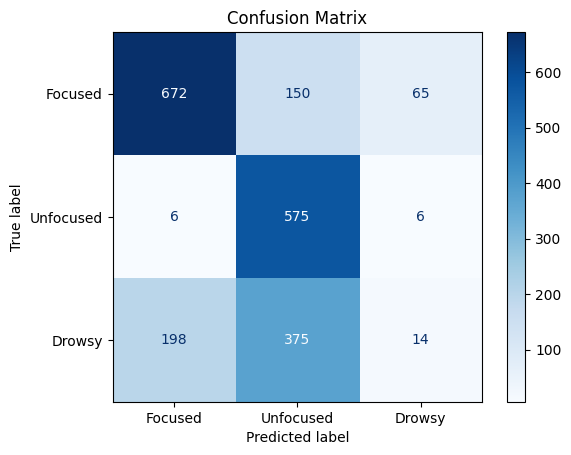

In [114]:
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_1 = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình trên tập train
rf_1.fit(X_train_scaled_1, y_train_1)

# Dự đoán trên tập test
y_pred_1 = rf_1.predict(X_test_scaled_1)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
rf_report_1 = classification_report(y_test_1, y_pred_1, output_dict=True)
print(rf_report_1)

plot_confusion_matrix(y_test_1, y_pred_1, class_names=["Focused", "Unfocused", "Drowsy"])

**Object 2**

In [81]:
# Chuẩn hóa dữ liệu
scaler_2 = StandardScaler()
X_train_scaled_2 = scaler_2.fit_transform(X_train_2)  # Fit và transform trên tập train
X_test_scaled_2 = scaler_2.transform(X_test_2)   

In [115]:
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_2 = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình trên tập train
rf_2.fit(X_train_scaled_2, y_train_2)

# Dự đoán trên tập test
y_pred_2 = rf_2.predict(X_test_scaled_2)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
rf_report_2 = classification_report(y_test_2, y_pred_2, output_dict=True)
print(rf_report_2)
 
# Vẽ ma trận nhầm lẫn
plot_confusion_matrix(y_test_2, y_pred_2, class_names=["Focused", "Unfocused", "Drowsy"])

Báo cáo đánh giá trên tập test:
{'Drowsy': {'precision': 0.8786359077231695, 'recall': 0.9875986471251409, 'f1-score': 0.9299363057324841, 'support': 887.0}, 'Focused': {'precision': 0.5508390918065152, 'recall': 0.9505962521294719, 'f1-score': 0.6975, 'support': 587.0}, 'Unfocused': {'precision': 0.7647058823529411, 'recall': 0.06643952299829642, 'f1-score': 0.12225705329153605, 'support': 587.0}, 'accuracy': 0.7147016011644832, 'macro avg': {'precision': 0.7313936272942086, 'recall': 0.6682114740843031, 'f1-score': 0.5832311196746734, 'support': 2061.0}, 'weighted avg': {'precision': 0.7528262736448579, 'recall': 0.7147016011644832, 'f1-score': 0.6336976678635833, 'support': 2061.0}}


**Object 3**

In [91]:
# Đếm số lượng từng nhãn
label_counts = Counter(y_train_3)

# Tạo DataFrame từ Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused   2348
1  Unfocused   2348
2     Drowsy   3548


In [83]:
# Chuẩn hóa dữ liệu
scaler_3 = StandardScaler()
X_train_scaled_3 = scaler_3.fit_transform(X_train_3)  # Fit và transform trên tập train
X_test_scaled_3 = scaler_3.transform(X_test_3)   

In [116]:
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_3 = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình trên tập train
rf_3.fit(X_train_scaled_3, y_train_3)

# Dự đoán trên tập test
y_pred_3 = rf_3.predict(X_test_scaled_3)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
rf_report_3 = classification_report(y_test_3, y_pred_3, output_dict=True)
print(rf_report_3)
 
plot_confusion_matrix(y_test_3, y_pred_3, class_names=["Focused", "Unfocused", "Drowsy"])

Báo cáo đánh giá trên tập test:
{'Drowsy': {'precision': 0.9152046783625731, 'recall': 0.705749718151071, 'f1-score': 0.7969446212603437, 'support': 887.0}, 'Focused': {'precision': 0.6829590488771466, 'recall': 0.8807495741056218, 'f1-score': 0.7693452380952381, 'support': 587.0}, 'Unfocused': {'precision': 0.4774193548387097, 'recall': 0.504258943781942, 'f1-score': 0.4904722452361226, 'support': 587.0}, 'accuracy': 0.6982047549733139, 'macro avg': {'precision': 0.6918610273594764, 'recall': 0.6969194120128783, 'f1-score': 0.6855873681972349, 'support': 2061.0}, 'weighted avg': {'precision': 0.7243710202274674, 'recall': 0.6982047549733139, 'f1-score': 0.701796575338881, 'support': 2061.0}}


**Object 4**

In [90]:
# Đếm số lượng từng nhãn
label_counts = Counter(y_train_4)

# Tạo DataFrame từ Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused   2348
1  Unfocused   2348
2     Drowsy   3548


In [85]:
# Chuẩn hóa dữ liệu
scaler_4 = StandardScaler()
X_train_scaled_4 = scaler_4.fit_transform(X_train_4)  # Fit và transform trên tập train
X_test_scaled_4 = scaler_4.transform(X_test_4)   

Báo cáo đánh giá trên tập test:
{'Drowsy': {'precision': 0.37559129612109743, 'recall': 0.8556034482758621, 'f1-score': 0.5220249835634451, 'support': 464.0}, 'Focused': {'precision': 0.819047619047619, 'recall': 0.293015332197615, 'f1-score': 0.4316185696361355, 'support': 587.0}, 'Unfocused': {'precision': 0.2722371967654987, 'recall': 0.17206132879045996, 'f1-score': 0.21085594989561587, 'support': 587.0}, 'accuracy': 0.409035409035409, 'macro avg': {'precision': 0.4889587039780717, 'recall': 0.440226703087979, 'f1-score': 0.38816650103173217, 'support': 1638.0}, 'weighted avg': {'precision': 0.497471641198101, 'recall': 0.409035409035409, 'f1-score': 0.3781148567390577, 'support': 1638.0}}


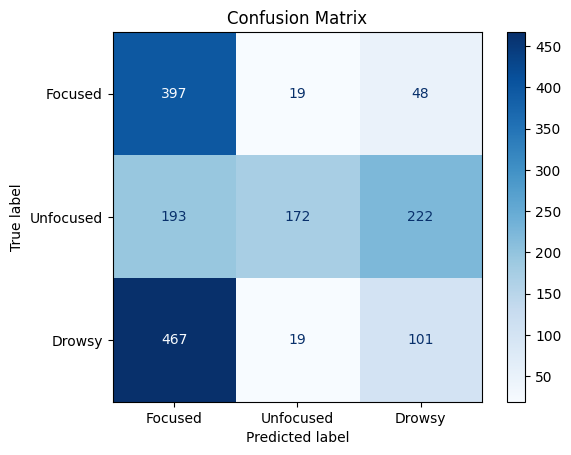

In [117]:
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_4 = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình trên tập train
rf_4.fit(X_train_scaled_4, y_train_4)

# Dự đoán trên tập test
y_pred_4 = rf_4.predict(X_test_scaled_4)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
rf_report_4 = classification_report(y_test_4, y_pred_4, output_dict=True)
print(rf_report_4)
 
# Vẽ ma trận nhầm lẫn
plot_confusion_matrix(y_test_4, y_pred_4, class_names=["Focused", "Unfocused", "Drowsy"])

**Object 5**

In [89]:
# Đếm số lượng từng nhãn
label_counts = Counter(y_train_5)

# Tạo DataFrame từ Counter
df_label_counts = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])

print(df_label_counts)

       Label  Count
0    Focused   1761
1  Unfocused   1761
2     Drowsy   2661


In [87]:
# Chuẩn hóa dữ liệu
scaler_5 = StandardScaler()
X_train_scaled_5 = scaler_5.fit_transform(X_train_5)  # Fit và transform trên tập train
X_test_scaled_5 = scaler_5.transform(X_test_5)   

Báo cáo đánh giá trên tập test:
              precision    recall  f1-score   support

      Drowsy       0.54      0.99      0.70       887
     Focused       0.70      0.49      0.58       587
   Unfocused       0.60      0.02      0.03       587

    accuracy                           0.57      2061
   macro avg       0.61      0.50      0.43      2061
weighted avg       0.60      0.57      0.47      2061



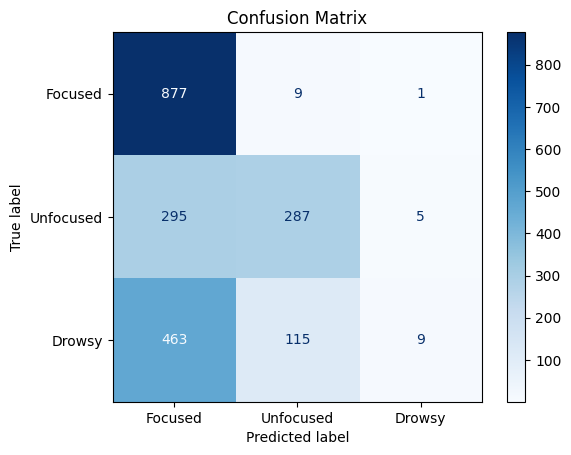

In [151]:
# Khởi tạo mô hình Random Forest, class_weight="balanced": điều chỉnh trọng số cho các lớp ko cân bằng
rf_5 = RandomForestClassifier(random_state=42)

# Huấn luyện mô hình trên tập train
rf_5.fit(X_train_scaled_5, y_train_5)

# Dự đoán trên tập test
y_pred_5 = rf_5.predict(X_test_scaled_5)

# Báo cáo hiệu suất
print("Báo cáo đánh giá trên tập test:")
rf_report_5 = classification_report(y_test_5, y_pred_5)
print(rf_report_5)
 
# Vẽ ma trận nhầm lẫn
plot_confusion_matrix(y_test_5, y_pred_5, class_names=["Focused", "Unfocused", "Drowsy"])



In [102]:
metrics_dict = {}


metrics_dict['Object 1'] = [rf_report_1['accuracy'], rf_report_1['macro avg']['precision'], 
                            rf_report_1['macro avg']['recall'], rf_report_1['macro avg']['f1-score']]

metrics_dict['Object 2'] = [rf_report_2['accuracy'], rf_report_2['macro avg']['precision'], 
                            rf_report_2['macro avg']['recall'], rf_report_2['macro avg']['f1-score']]

metrics_dict['Object 3'] = [rf_report_3['accuracy'], rf_report_3['macro avg']['precision'], 
                            rf_report_3['macro avg']['recall'], rf_report_3['macro avg']['f1-score']]

metrics_dict['Object 4'] = [rf_report_4['accuracy'], rf_report_4['macro avg']['precision'], 
                            rf_report_4['macro avg']['recall'], rf_report_4['macro avg']['f1-score']]

metrics_dict['Object 5'] = [rf_report_5['accuracy'], rf_report_5['macro avg']['precision'], 
                            rf_report_5['macro avg']['recall'], rf_report_5['macro avg']['f1-score']]

# Chuyển dictionary thành DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Hiển thị DataFrame
print(metrics_df.round(2))

           Object 1  Object 2  Object 3  Object 4  Object 5
Accuracy       0.61      0.71      0.70      0.41      0.57
Precision      0.48      0.73      0.69      0.49      0.61
Recall         0.59      0.67      0.70      0.44      0.50
F1-Score       0.50      0.58      0.69      0.39      0.43


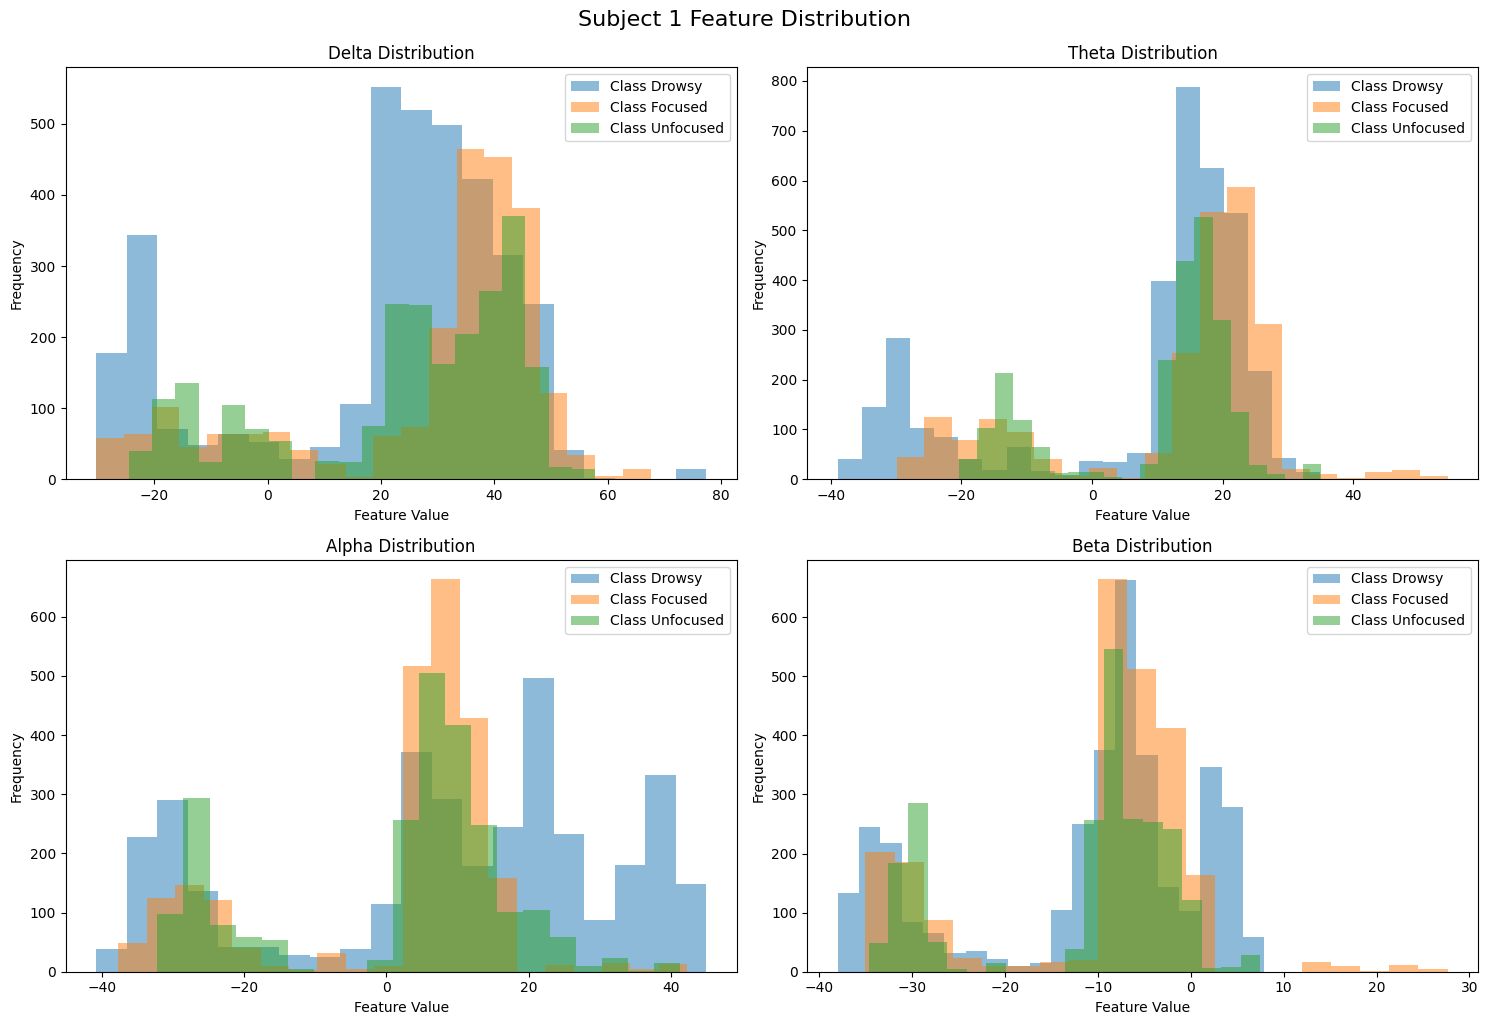

In [129]:
def visualize_feature_distribution(features, labels, feature_names, title="Feature Distribution"):
    """
    Visualize feature distribution across classes using histograms.
    """
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 10))
    
    for i, feature_name in enumerate(feature_names):
        plt.subplot(2, 2, i + 1)
        for label in unique_labels:
            plt.hist(features[labels == label, i], bins=20, alpha=0.5, label=f"Class {label}")
        plt.title(f"{feature_name} Distribution")
        plt.xlabel("Feature Value")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

# Example: Visualize feature distributions for Subject 1
visualize_feature_distribution(X_train_1, y_train_1, ["Delta", "Theta", "Alpha", "Beta"], title="Subject 1 Feature Distribution")


- Delta và Theta: Cao hơn rõ rệt ở trạng thái Drowsy, cho thấy chúng đại diện cho sự buồn ngủ và mất tập trung.
- Alpha: Thể hiện mạnh nhất ở trạng thái Focused, liên quan đến sự thư giãn và tập trung nhẹ.
- Beta: Nổi bật ở trạng thái Focused, phản ánh sự tỉnh táo và tập trung cao độ.
- Ý nghĩa:
   + Drowsy được phân biệt nhờ Delta và Theta.
   + Focused được phân biệt nhờ Alpha và Beta

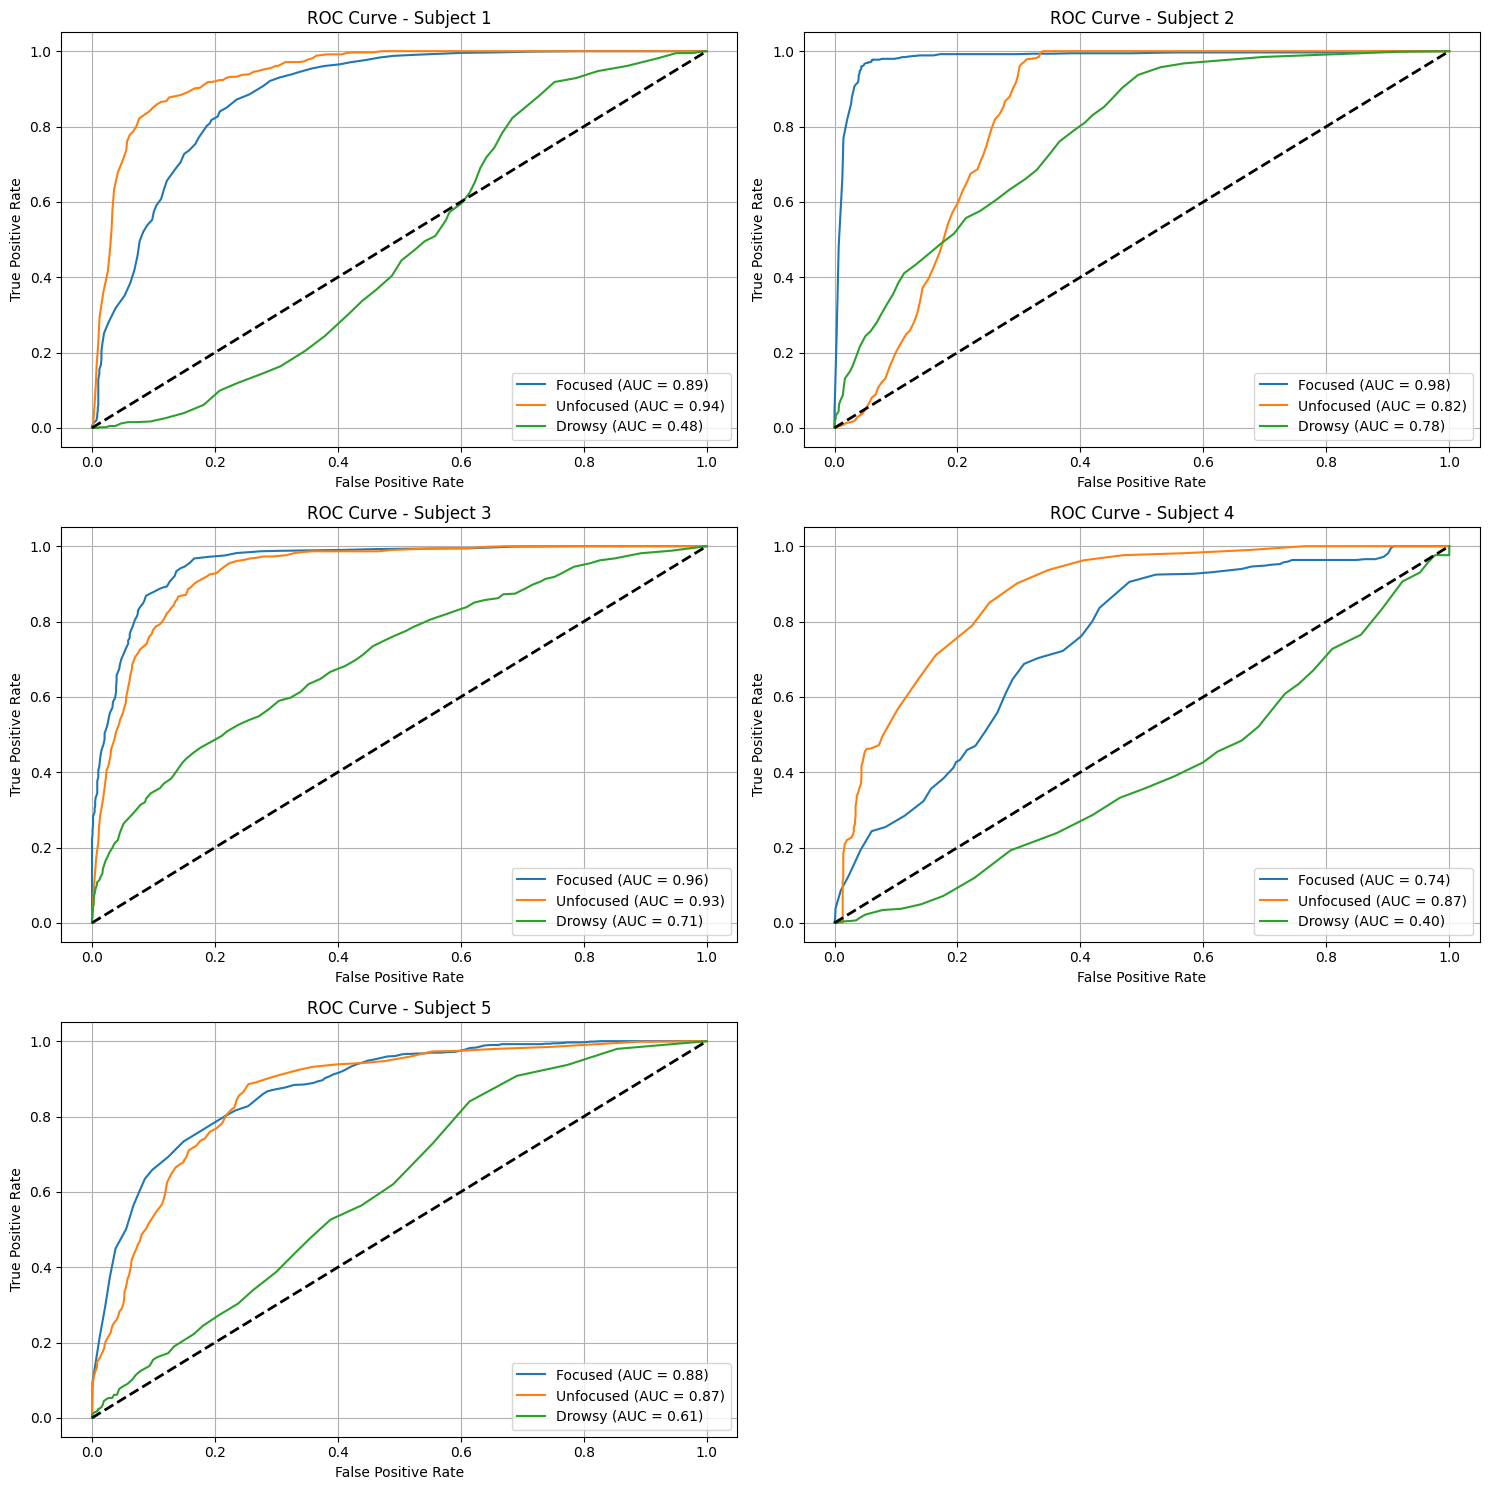

In [150]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curves_combined(models, X_tests, y_tests, class_names):
    """
    Plot ROC curves for 5 subjects in a combined grid layout (2x2 + 1 separate plot below).
    models: list of trained models (e.g., Random Forests for each subject).
    X_tests: list of test datasets for each subject.
    y_tests: list of true labels for each subject.
    class_names: list of class names (for multi-class ROC).
    """
    plt.figure(figsize=(15, 15))  # Tăng chiều cao để khớp các plot
    gridspec = plt.GridSpec(3, 2)  # Chia grid 3 hàng, 2 cột

    for i, (model, X_test, y_test) in enumerate(zip(models, X_tests, y_tests)):
        y_prob = model.predict_proba(X_test)  # Predicted probabilities
        y_true_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize labels
        n_classes = y_true_bin.shape[1]

        # Vị trí plot trong lưới
        if i < 4:  # 2x2 grid cho 4 subject đầu
            ax = plt.subplot(gridspec[i // 2, i % 2])  # Hàng, cột dựa trên thứ tự
        else:  # Subject 5 ở hàng cuối, cột đầu tiên
            ax = plt.subplot(gridspec[2, 0])  # Đặt vào hàng 3, cột 1

        # Plot ROC cho từng class
        for j in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, j], y_prob[:, j])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f"{class_names[j]} (AUC = {roc_auc:.2f})")
        
        ax.plot([0, 1], [0, 1], "k--", lw=2)  # Đường chéo
        ax.set_title(f"ROC Curve - Subject {i + 1}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend(loc="lower right")
        ax.grid()

    # Ẩn ô cuối cùng (hàng 3, cột 2) để không hiển thị trống
    plt.subplot(gridspec[2, 1]).axis("off")

    plt.tight_layout()
    plt.show()

# Example Usage
models = [rf_1, rf_2, rf_3, rf_4, rf_5]
X_tests = [X_test_scaled_1, X_test_scaled_2, X_test_scaled_3, X_test_scaled_4, X_test_scaled_5]
y_tests = [y_test_1, y_test_2, y_test_3, y_test_4, y_test_5]
class_names = ["Focused", "Unfocused", "Drowsy"]

# Plot combined ROC curves
plot_roc_curves_combined(models, X_tests, y_tests, class_names)


### **Nhận xét Biểu Đồ ROC Curve cho 5 Subjects**

#### **Subject 1**
- **Focused (AUC = 0.89)** và **Unfocused (AUC = 0.94)** cho kết quả tốt.
- **Drowsy (AUC = 0.48)** rất thấp, cho thấy mô hình gặp khó khăn trong việc phân biệt trạng thái Drowsy với các trạng thái khác.

#### **Subject 2**
- **Focused (AUC = 0.98)** đạt kết quả xuất sắc.
- **Unfocused (AUC = 0.82)** và **Drowsy (AUC = 0.78)** khá tốt, nhưng trạng thái Drowsy có độ chồng chéo cao hơn so với Focused.

#### **Subject 3**
- **Focused (AUC = 0.96)** và **Unfocused (AUC = 0.93)** đạt độ phân biệt rất cao.
- **Drowsy (AUC = 0.71)** ở mức trung bình, nhưng vẫn tốt hơn các subject khác trong việc phân biệt trạng thái buồn ngủ.

#### **Subject 4**
- **Unfocused (AUC = 0.87)** vượt trội hơn các trạng thái còn lại.
- **Focused (AUC = 0.74)** khá thấp, cho thấy sự khó khăn trong việc xác định trạng thái tập trung.
- **Drowsy (AUC = 0.40)** rất thấp, không đủ để phân biệt với các trạng thái khác.

#### **Subject 5**
- **Focused (AUC = 0.88)** và **Unfocused (AUC = 0.87)** gần như tương đương, đạt kết quả tốt.
- **Drowsy (AUC = 0.61)** ở mức trung bình, nhưng thấp hơn so với hai trạng thái còn lại.


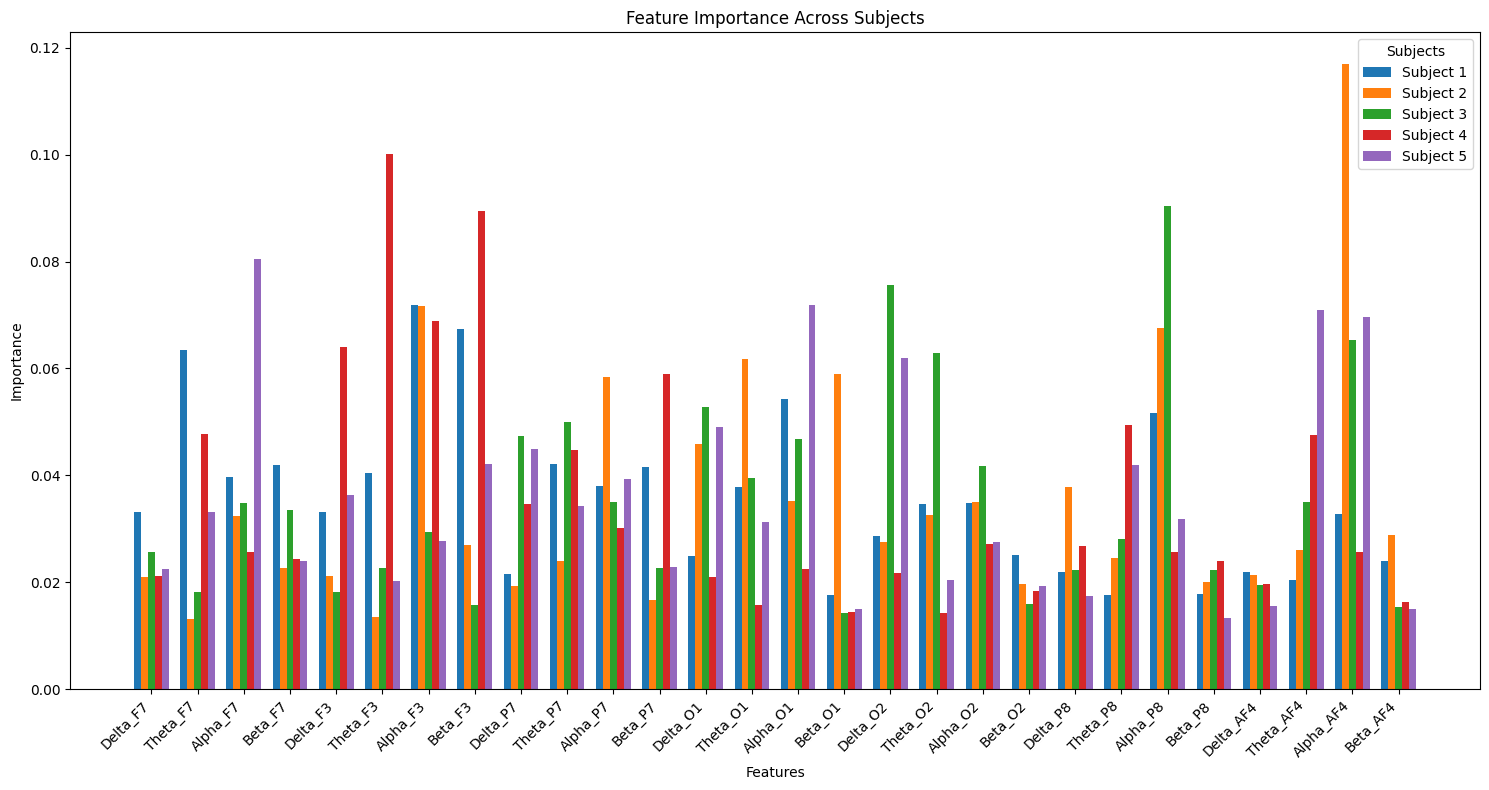

In [147]:
def plot_feature_importance_multiple(models, feature_names, subject_names):
    """
    Plot feature importance for multiple subjects in a grouped bar plot.
    models: list of trained Random Forest models (one for each subject).
    feature_names: list of feature names.
    subject_names: list of subject names.
    """
    num_features = len(feature_names)
    num_subjects = len(models)
    
    # Collect feature importances for all subjects
    importances = np.zeros((num_subjects, num_features))
    for i, model in enumerate(models):
        importances[i, :] = model.feature_importances_
    
    # Define bar width and positions
    bar_width = 0.15
    x = np.arange(num_features)  # X-axis positions for features
    offsets = np.arange(-(num_subjects - 1) / 2, (num_subjects + 1) / 2) * bar_width  # Offsets for subjects
    
    # Plot grouped bar chart
    plt.figure(figsize=(15, 8))
    for i, (importance, offset) in enumerate(zip(importances, offsets)):
        plt.bar(x + offset, importance, bar_width, label=subject_names[i])
    
    # Add labels, legend, and formatting
    plt.xticks(x, feature_names, rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.title("Feature Importance Across Subjects")
    plt.legend(title="Subjects")
    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming rf_1, rf_2, rf_3, rf_4, rf_5 are Random Forest models for 5 subjects
models = [rf_1, rf_2, rf_3, rf_4, rf_5]
subject_names = ["Subject 1", "Subject 2", "Subject 3", "Subject 4", "Subject 5"]

# Generate feature names (e.g., for 7 channels and 4 frequency bands)
channels = ["F7", "F3", "P7", "O1", "O2", "P8", "AF4"]
feature_names = [f"{band}_{channel}" for channel in channels for band in ["Delta", "Theta", "Alpha", "Beta"]]

# Plot feature importance for all subjects
plot_feature_importance_multiple(models, feature_names, subject_names)


### **Nhận xét về Feature Importance Across Subjects**

#### **1. Sự khác biệt giữa các Subjects**
- Các đặc trưng quan trọng (**importance**) thay đổi đáng kể giữa các subjects.
- Điều này cho thấy **tính cá nhân hóa cao** trong tín hiệu EEG, nơi mỗi subject có thể có các đặc trưng riêng biệt liên quan đến các trạng thái khác nhau (**Focused**, **Unfocused**, **Drowsy**).

#### **2. Dải tần Delta và Theta**
- **Delta** và **Theta** thường có **importance cao hơn** ở một số kênh như **F7**, **P7**, và **O1**, đặc biệt rõ ràng với **Subject 1** và **Subject 5**.
- Phù hợp với đặc trưng của các trạng thái **buồn ngủ** hoặc **thiếu tập trung** (**Drowsy/Unfocused**).

#### **3. Dải tần Alpha và Beta**
- **Alpha** và **Beta** nổi bật ở các kênh như **AF4** và **P8**, đặc biệt rõ ở **Subject 2** và **Subject 4**.
- Hai dải này thường liên quan đến sự **tập trung** (**Focused**).

#### **4. Kênh EEG**
- Các kênh phía sau như **O1**, **O2**, và **P8** có xu hướng được sử dụng nhiều hơn ở tất cả các subjects.
- Kênh **F7** và **AF4** cũng đóng vai trò quan trọng, liên quan đến hoạt động vùng trước trán (**frontal lobe**).

#### **5. Tính nhất quán**
- Không có đặc trưng (**kênh + dải tần**) nào quan trọng đồng đều trên tất cả các subjects.
- Điều này nhấn mạnh sự cần thiết của:
  - Thiết lập **mô hình cá nhân hóa** cho từng subject.
  - Sử dụng **chiến lược tổng hợp (ensemble)** để giảm sự thay đổi giữa các subjects.

---

### **Ý nghĩa**
1. **Tính cá nhân hóa cao**:
   - Tầm quan trọng của các đặc trưng thay đổi theo subject.
   - Cần thiết lập mô hình riêng cho từng subject hoặc các phương pháp tổng hợp dữ liệu hiệu quả.

2. **Delta và Theta cho trạng thái Drowsy**:
   - Hai dải tần này chiếm ưu thế trong việc đại diện cho trạng thái **buồn ngủ hoặc mất tập trung**.

3. **Alpha và Beta cho trạng thái Focused**:
   - Các dải này được ưu tiên hơn trong trạng thái **tập trung**, đặc biệt ở các kênh vùng trước trán và thái dương.
